# Bluetooth DoS Classifier

This experiment tries Random Forest with the results of the last experiment. The goal is to see if only using Time and Length improves the accuracy of the classifier.

**Findings:**

- Training time is much longer (2.5m vs 1m)
- Performance is the same as the previous experiment (lower on demo data)

## Setup

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import sklearn.metrics as metrics
from joblib import dump, load
from scipy.sparse import csr_matrix, hstack, load_npz, save_npz
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

In [3]:
DATA = os.path.abspath("../data")
MODELS = os.path.abspath("../models")

# data paths
ATTACK_TRAIN = os.path.join(DATA, "dos_train.csv")
BENIGN_TRAIN = os.path.join(DATA, "benign_train.csv")
ATTACK_TEST = os.path.join(DATA, "dos_test.csv")
BENIGN_TEST = os.path.join(DATA, "benign_test.csv")
CAPTURED_DATA = os.path.join(DATA, "capture.csv")

# preprocessed data paths
PREPROCESSED_TRAIN = os.path.join(DATA, "preprocessed_train.csv")
PREPROCESSED_TEST = os.path.join(DATA, "preprocessed_test.csv")
LABELS_TRAIN = os.path.join(DATA, f"labels_train.npy")
LABELS_TEST = os.path.join(DATA, f"labels_test.npy")

# features paths
FEATURES_TEST = os.path.join(DATA, f"features_test.npz")
FEATURES_TRAIN = os.path.join(DATA, f"features_train.npz")

# models paths
MODEL = os.path.join(MODELS, f"rand_forest.joblib")  # random forest model

In [12]:
print("Data directory:", DATA)
print("Models directory:", MODELS)

# check that data files exist
data_paths = [ATTACK_TRAIN, BENIGN_TRAIN, ATTACK_TEST, BENIGN_TEST]
if not all(map(os.path.exists, data_paths)):
    raise Exception("Data files not found")

# create directories if they don't exist
if not os.path.exists(MODELS):
    os.makedirs("models")

# format plots
plt.style.use(["science", "ieee"])

Data directory: /Users/mohdfareed/Developer/school/bt-attacks-detector/data
Models directory: /Users/mohdfareed/Developer/school/bt-attacks-detector/models


## Dataset Preprocessing

In [4]:
# read datasets
attack_train = pd.read_csv(ATTACK_TRAIN)
benign_train = pd.read_csv(BENIGN_TRAIN)
attack_test = pd.read_csv(ATTACK_TEST)
benign_test = pd.read_csv(BENIGN_TEST)
capture = pd.read_csv(CAPTURED_DATA)

In [5]:
# split captured data (80/20 split) and append to benign data
split_index = int(len(capture) * 0.8)  # required to preserve order
capture_train = capture.iloc[:split_index]
capture_test = capture.iloc[split_index:]
benign_train = pd.concat([benign_train, capture_train], ignore_index=True)
benign_test = pd.concat([benign_test, capture_test], ignore_index=True)

# add type column indicating attack or benign
attack_train["Type"] = 1
attack_test["Type"] = 1
benign_train["Type"] = 0
benign_test["Type"] = 0

# combine datasets
train_dataset = pd.concat([attack_train, benign_train], ignore_index=True)
test_dataset = pd.concat([attack_test, benign_test], ignore_index=True)

# generate labels
train_labels = train_dataset["Type"]
train_dataset.drop(columns=["Type"], inplace=True)
test_labels = test_dataset["Type"]
test_dataset.drop(columns=["Type"], inplace=True)

In [6]:
# write preprocessed dataset to files
train_dataset.to_csv(PREPROCESSED_TRAIN, index=False)
test_dataset.to_csv(PREPROCESSED_TEST, index=False)
np.save(LABELS_TRAIN, train_labels)
np.save(LABELS_TEST, test_labels)

Training and Testing dataset statistics:
                No.          Time        Length          Type
count  2.533706e+06  2.533706e+06  2.533706e+06  2.533706e+06
mean   4.170342e+05  1.993675e+05  6.519739e+01  4.933876e-01
std    3.039178e+05  3.693308e+05  1.507927e+02  4.999564e-01
min    1.000000e+00  0.000000e+00  3.000000e+00  0.000000e+00
25%    1.420250e+05  1.257302e+03  8.000000e+00  0.000000e+00
50%    3.661615e+05  3.491526e+03  1.900000e+01  0.000000e+00
75%    6.828748e+05  9.224927e+04  3.200000e+01  1.000000e+00
max    1.000784e+06  1.198804e+06  1.021000e+03  1.000000e+00



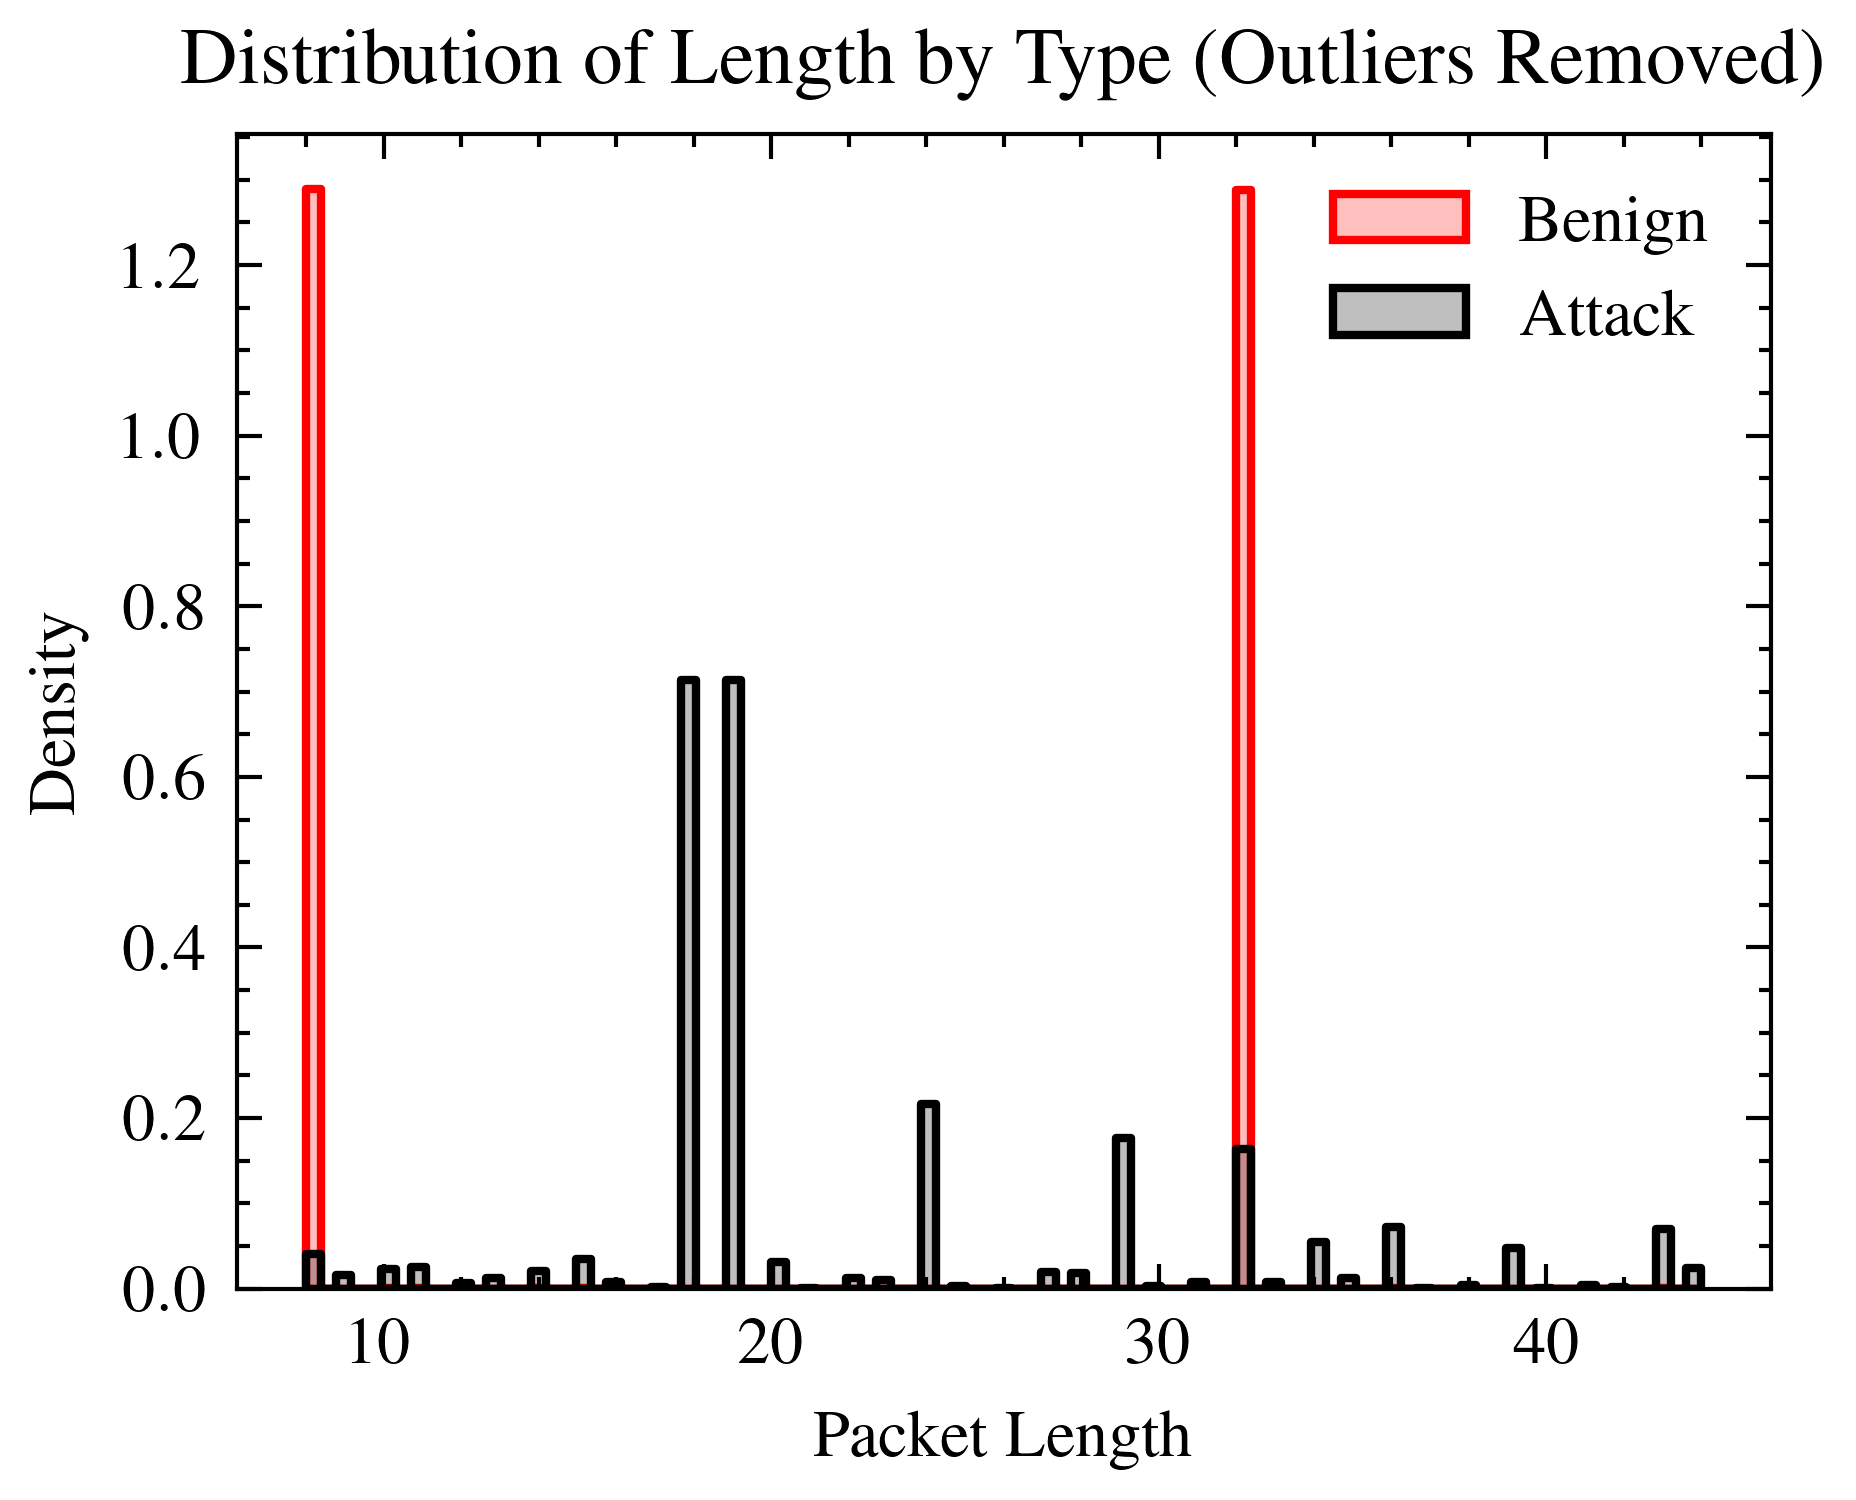

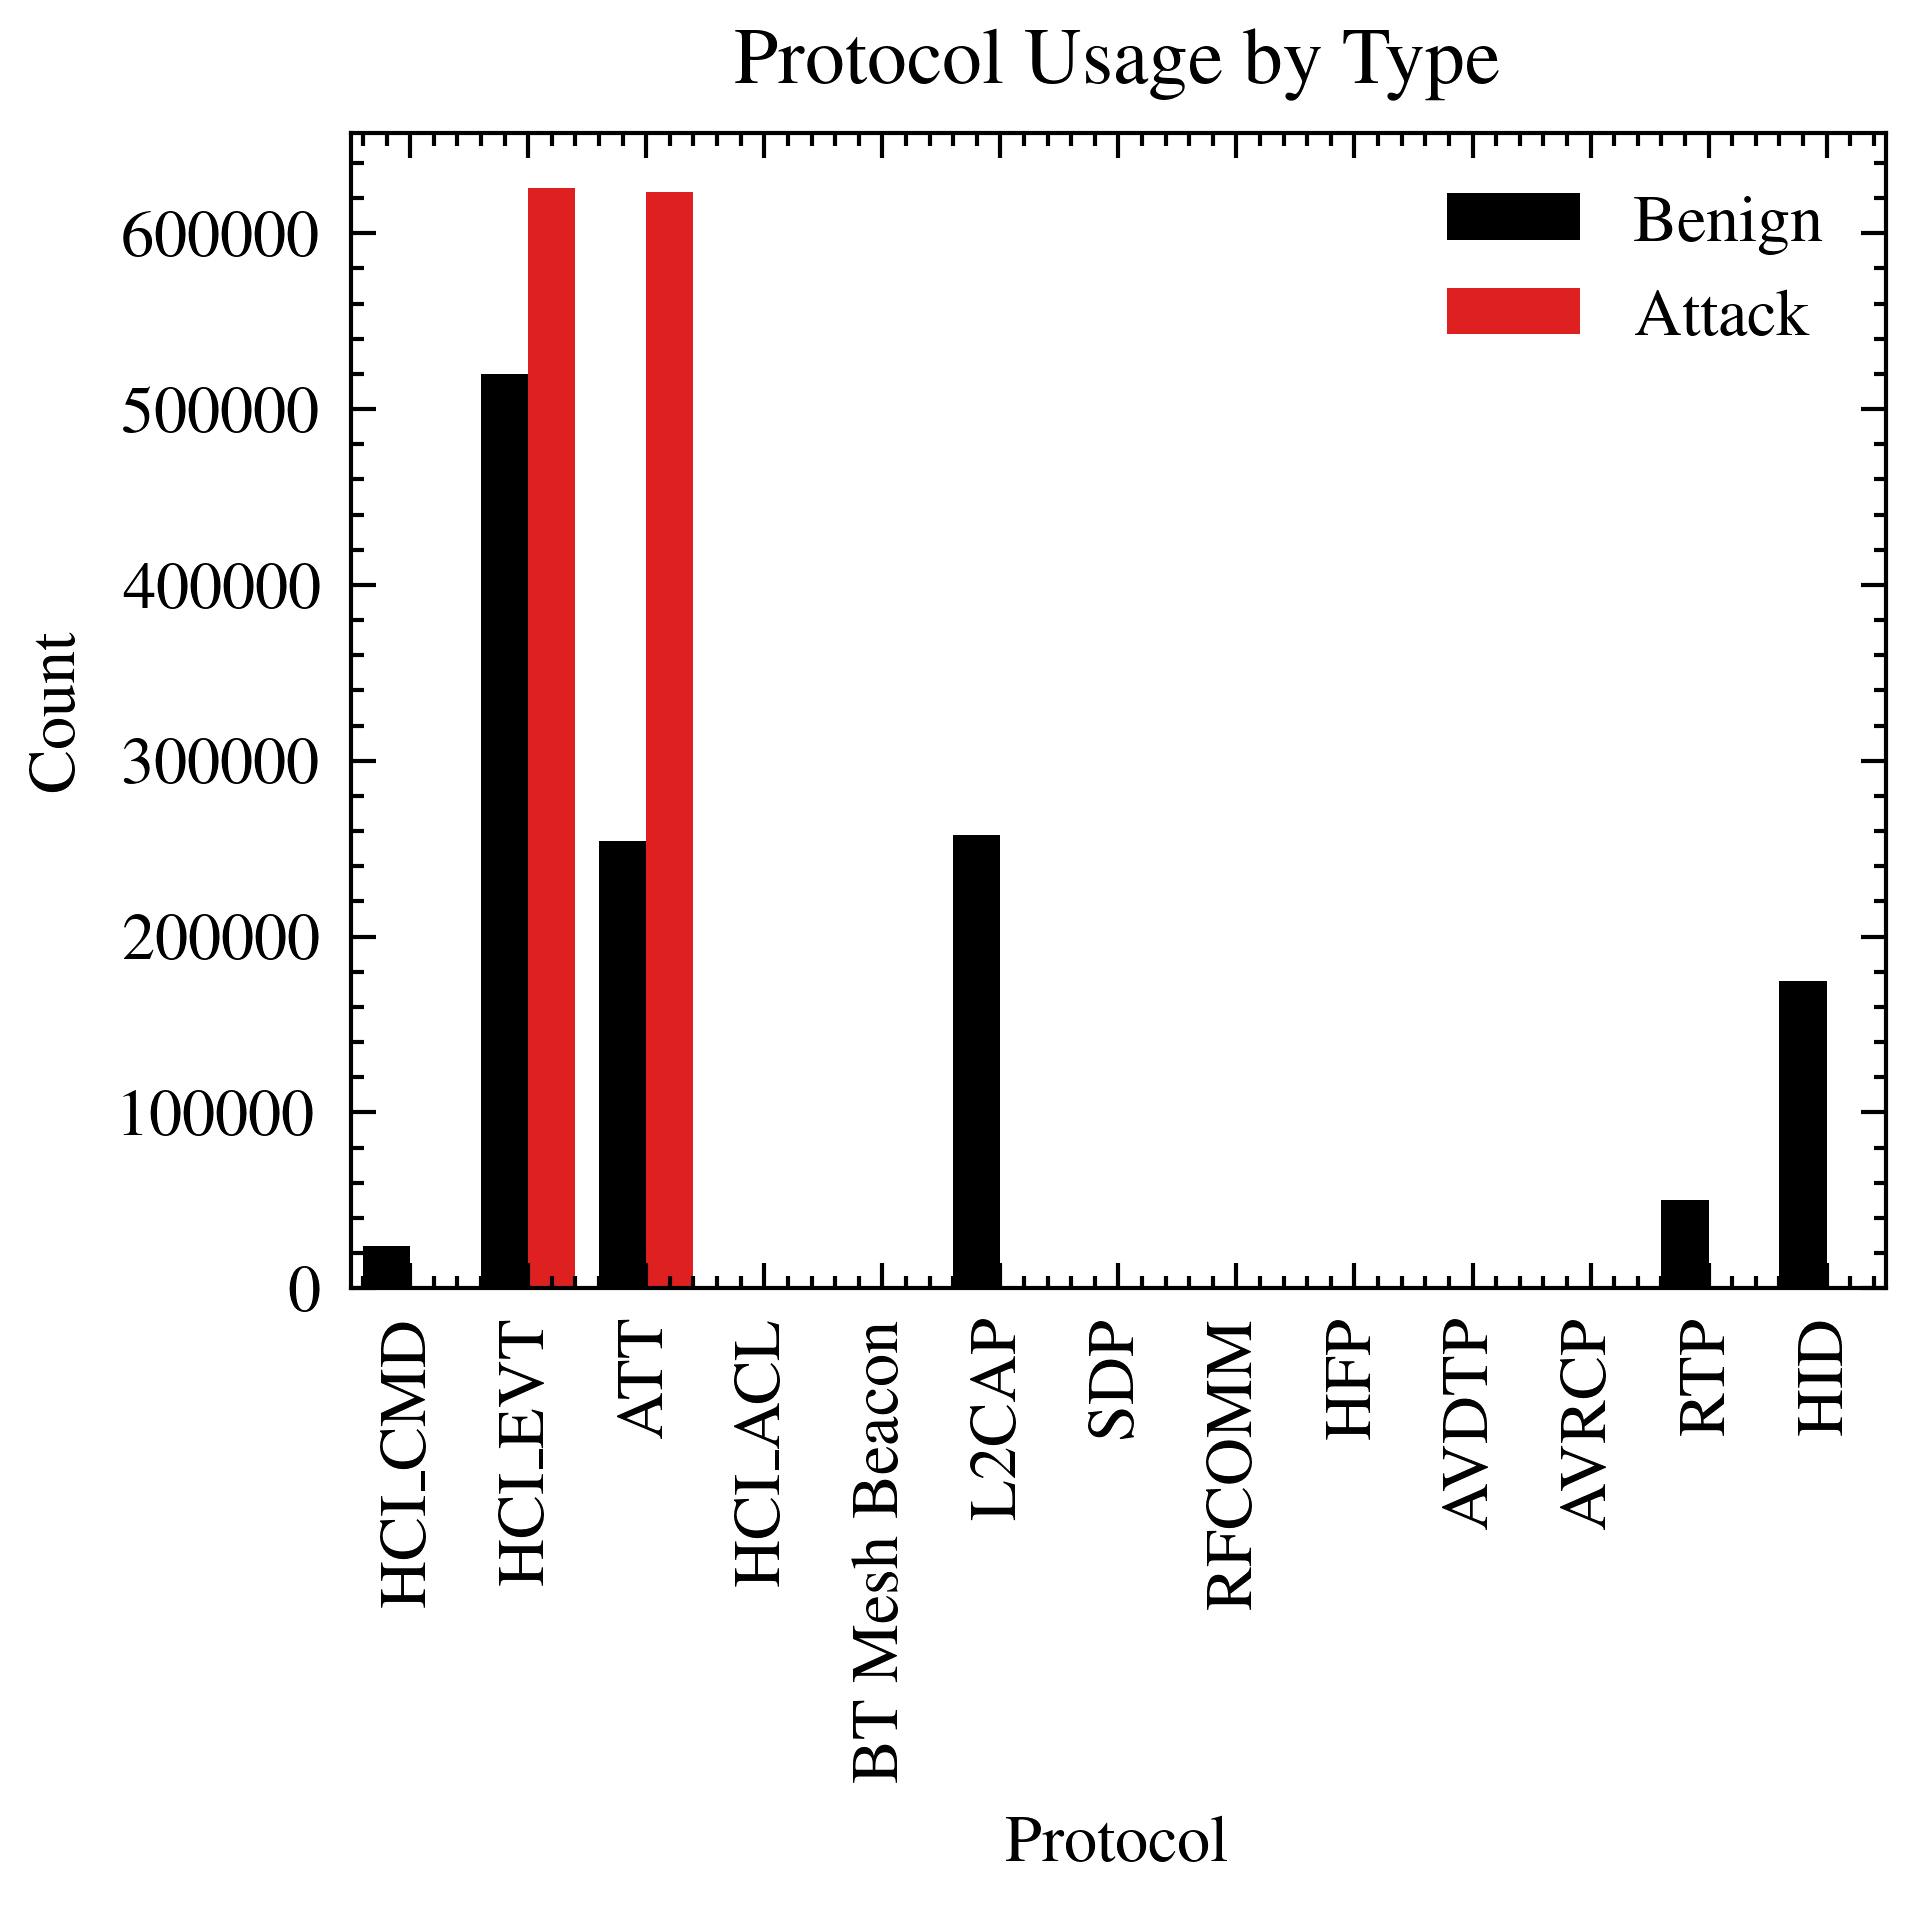

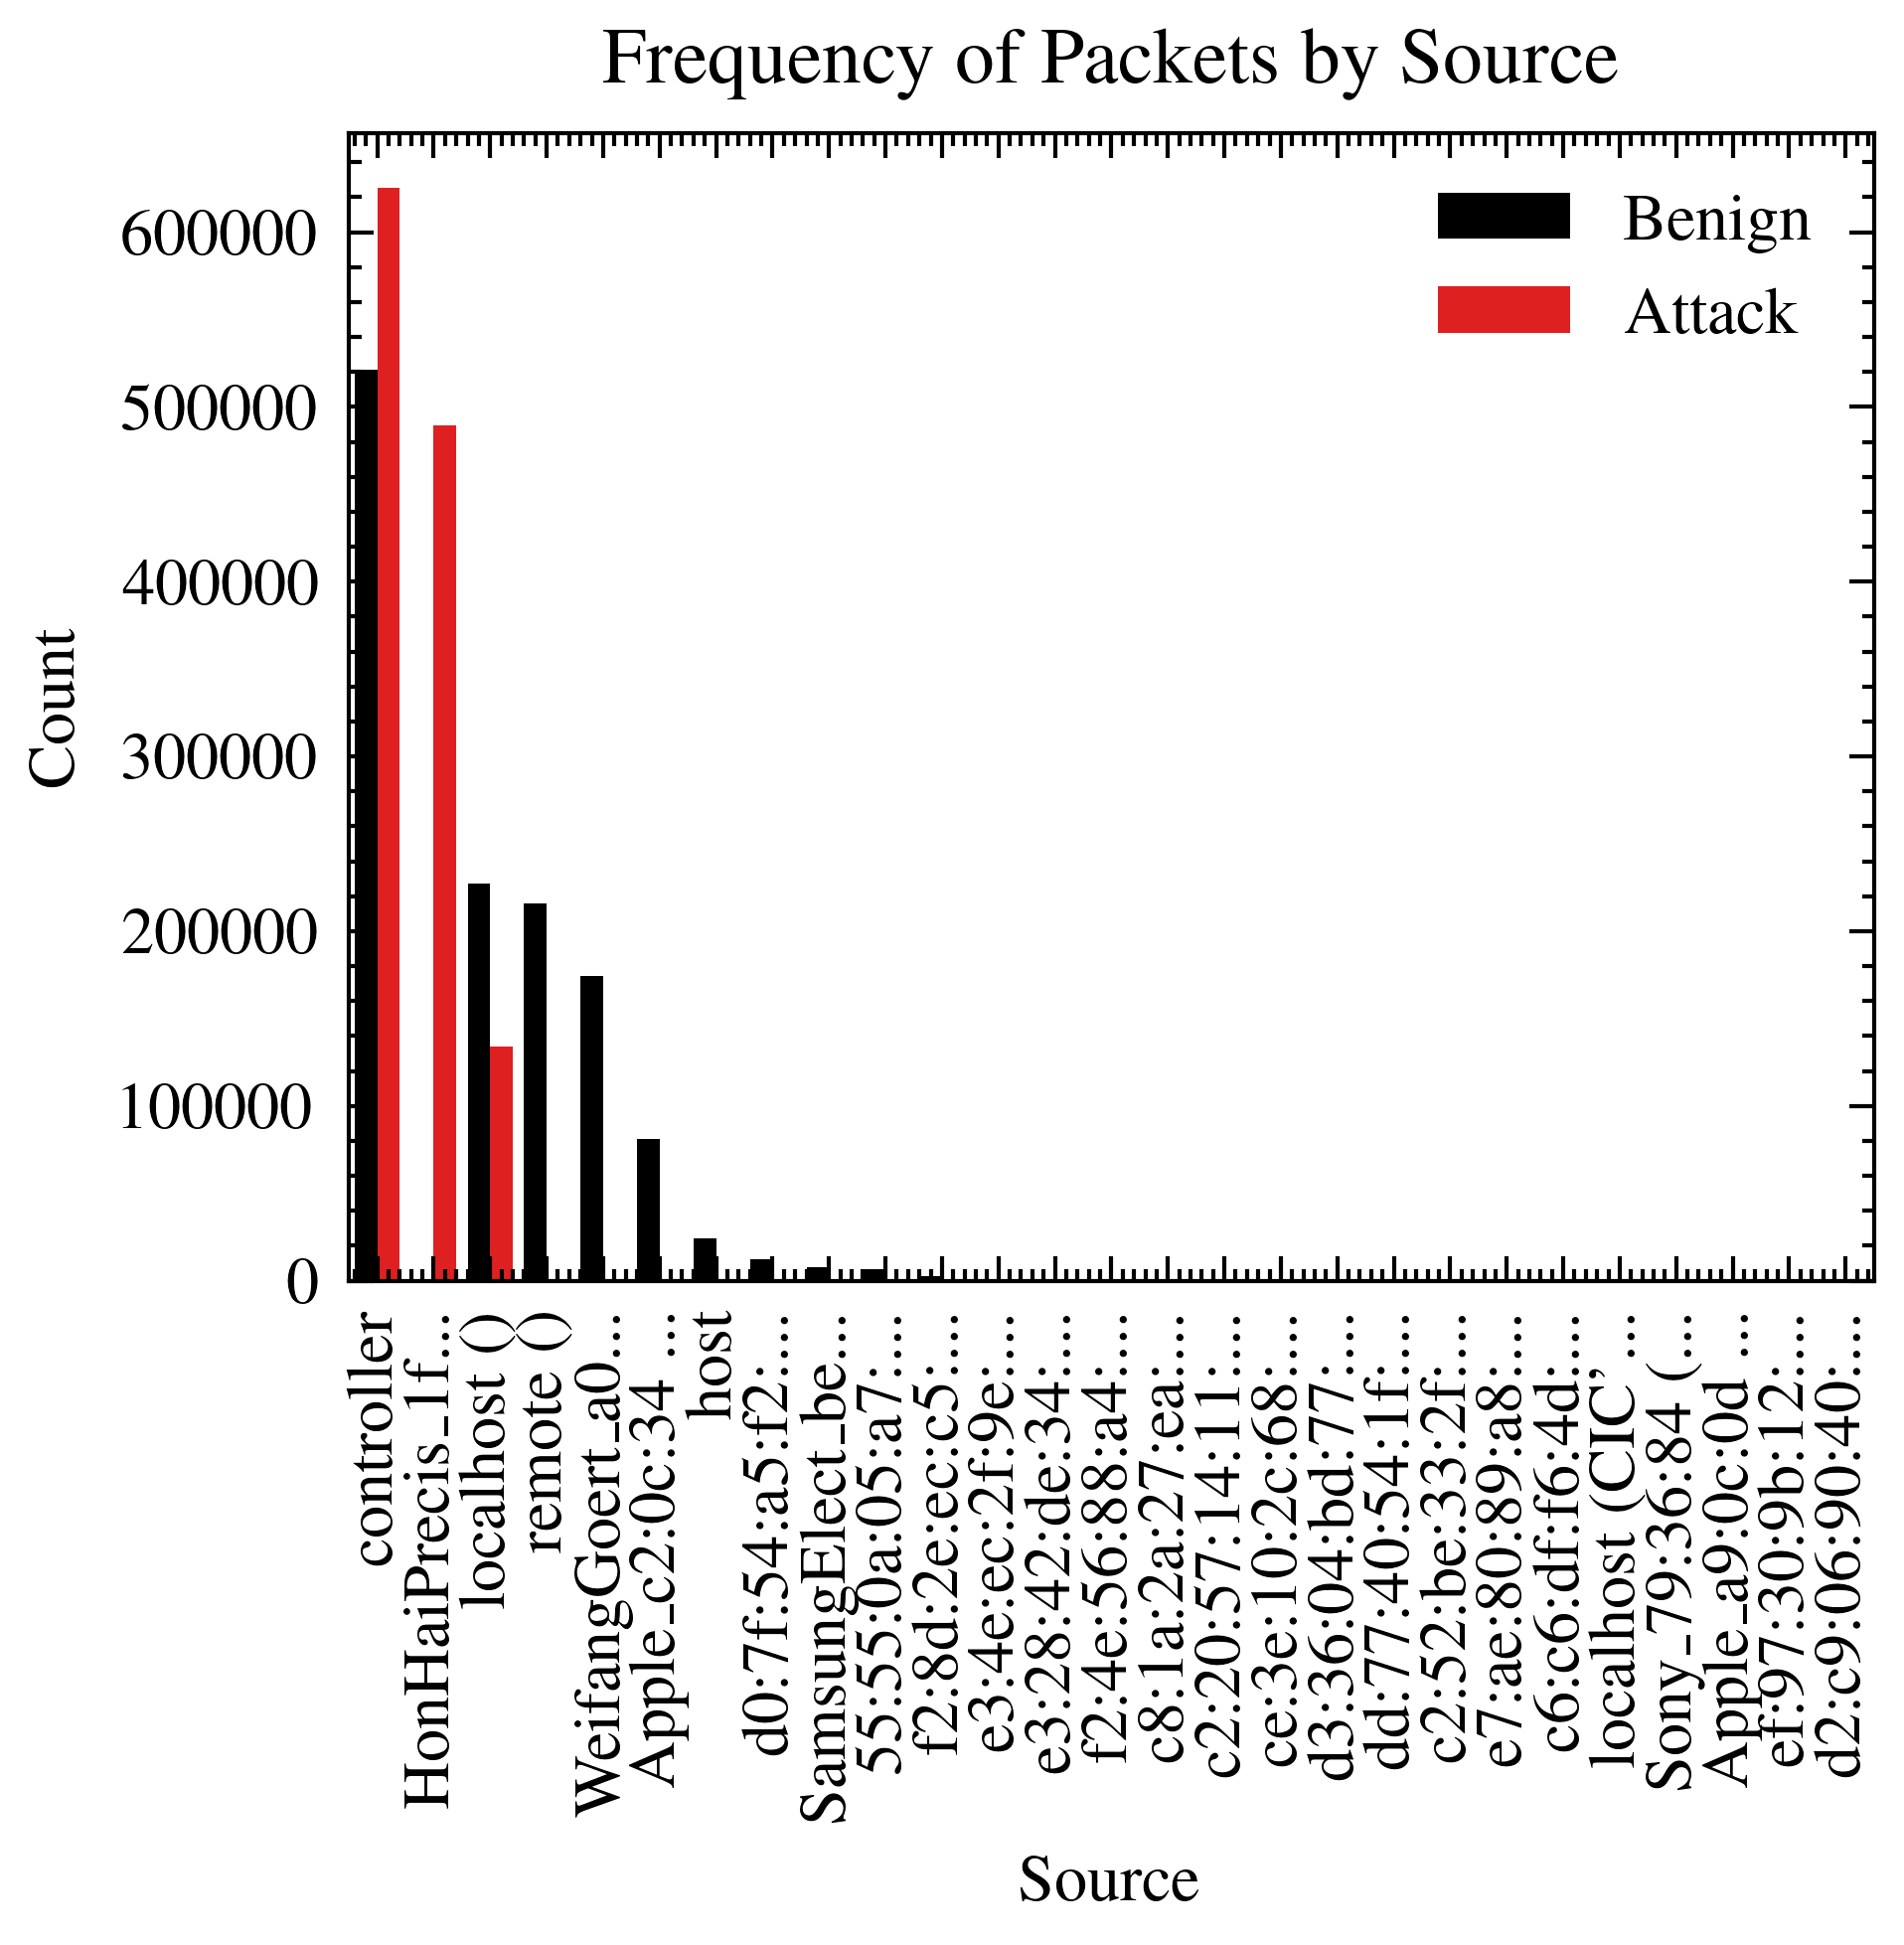

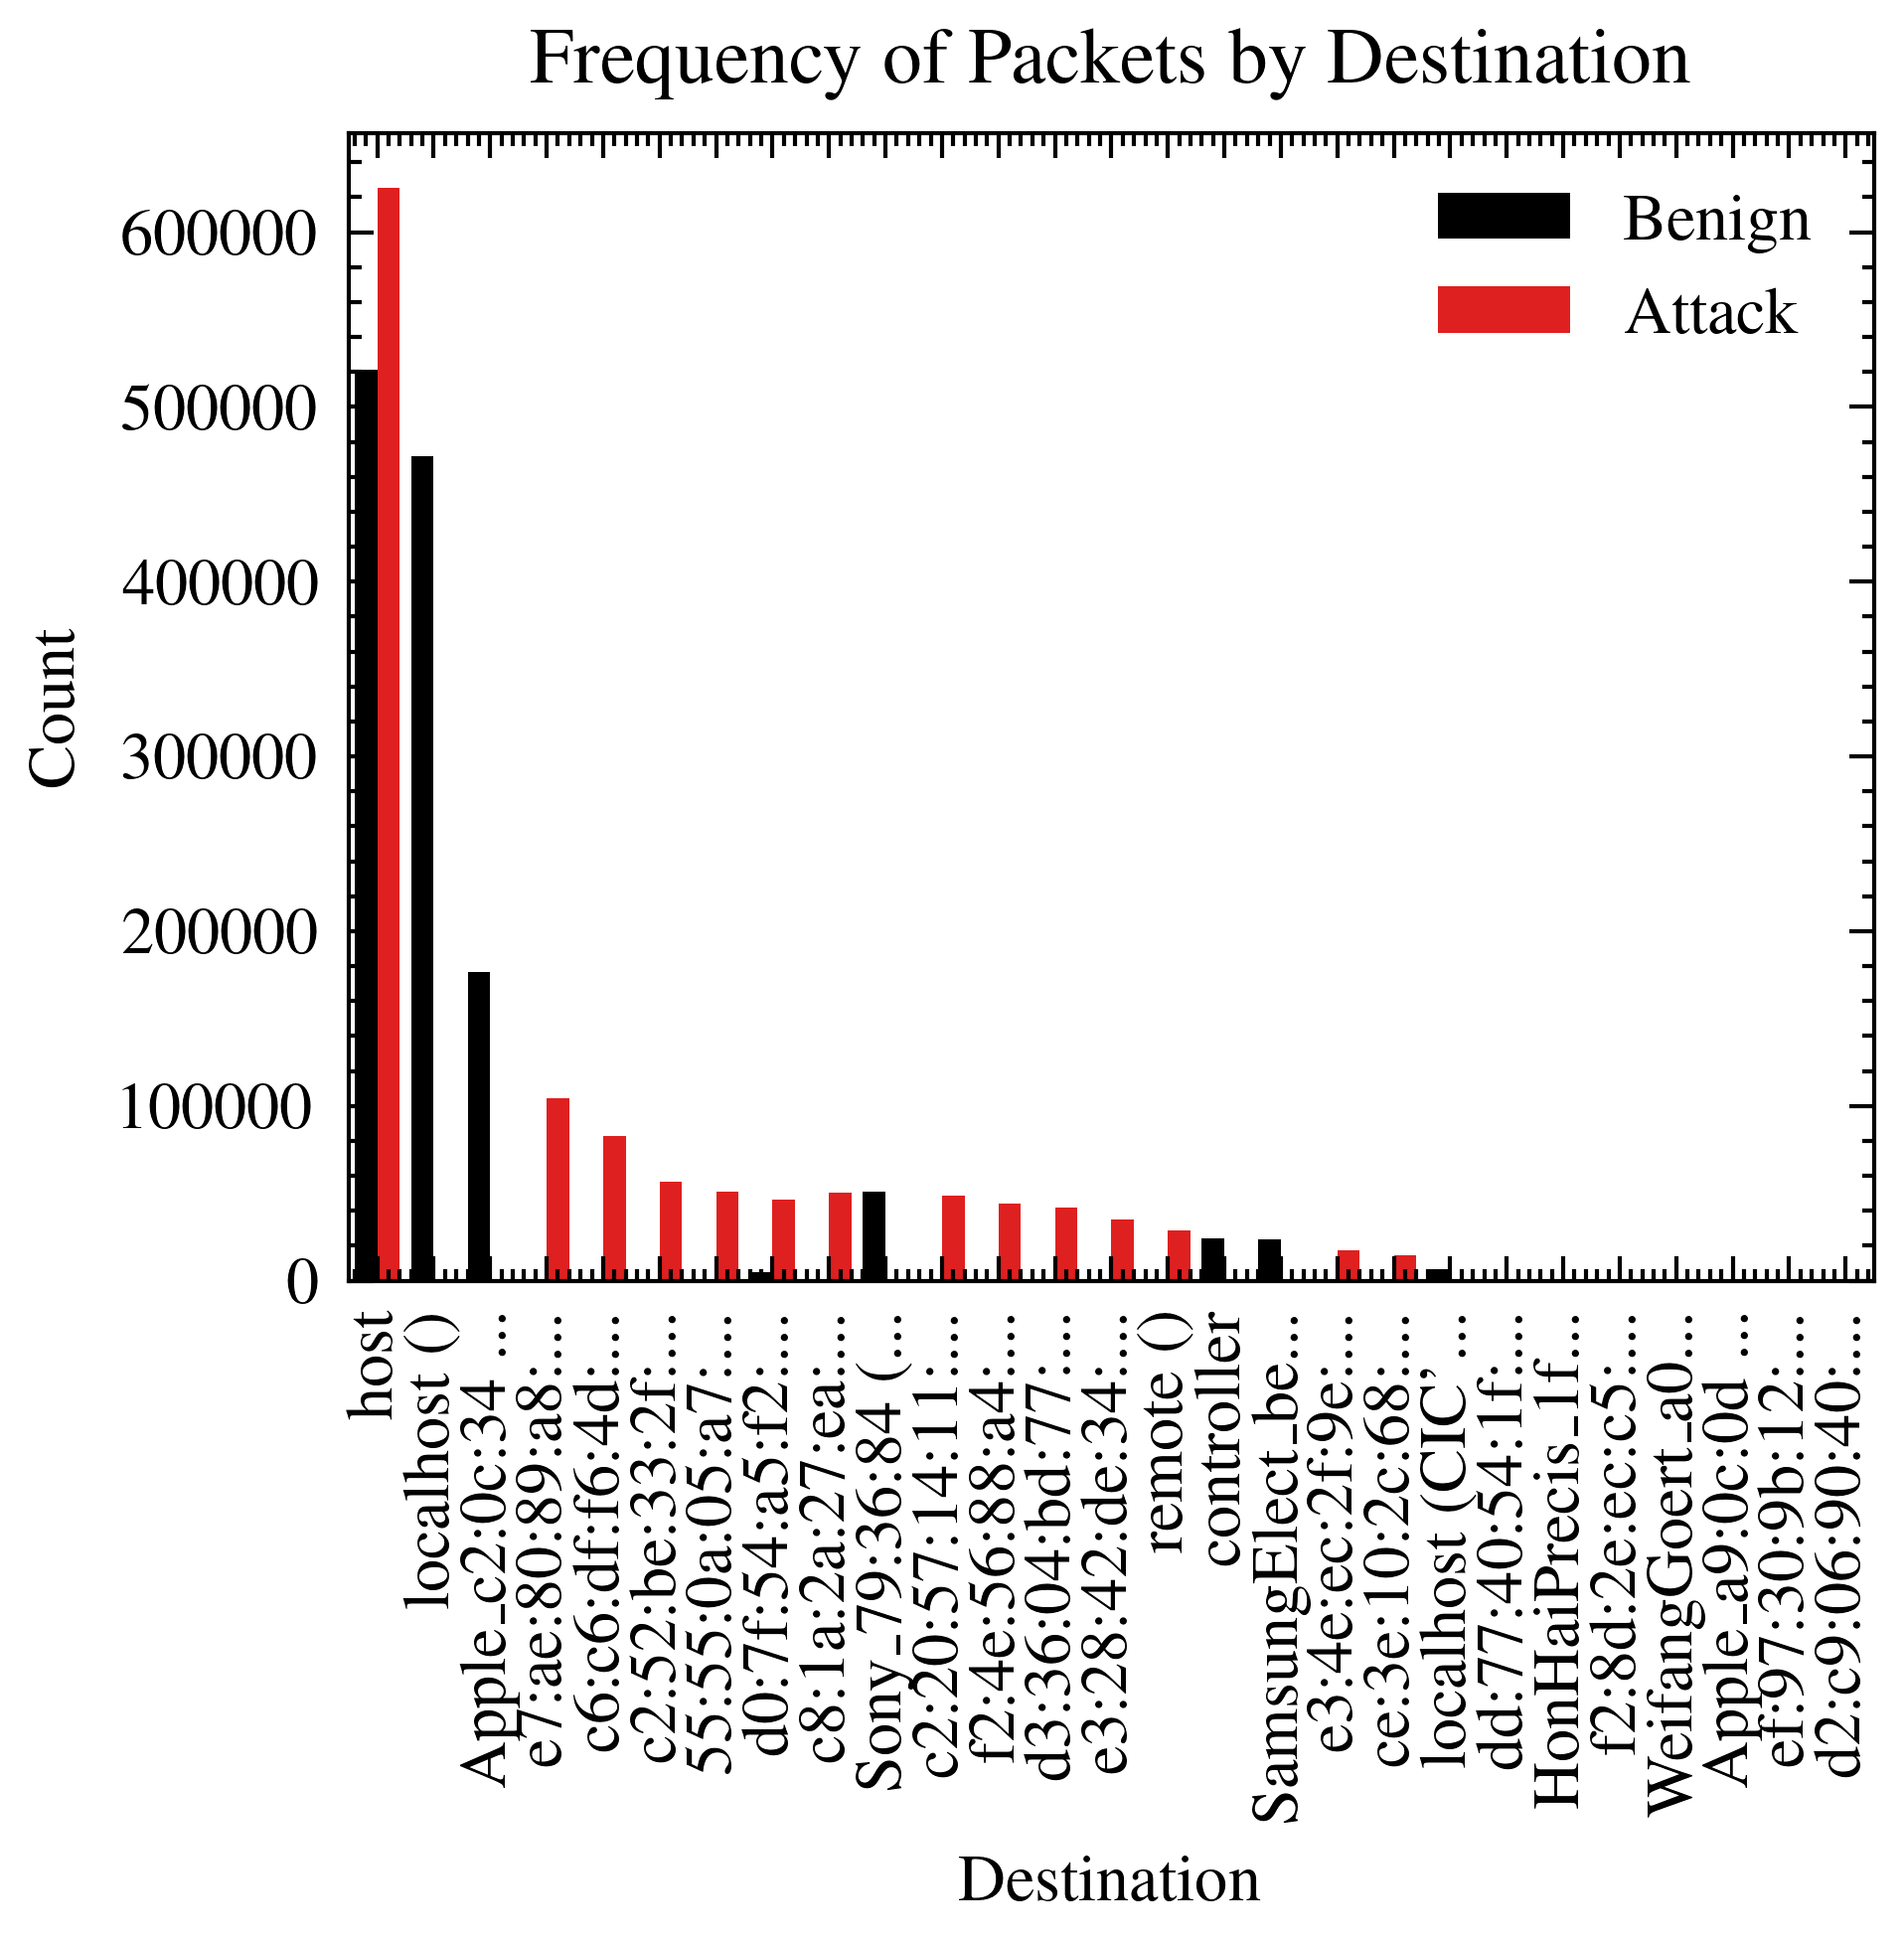

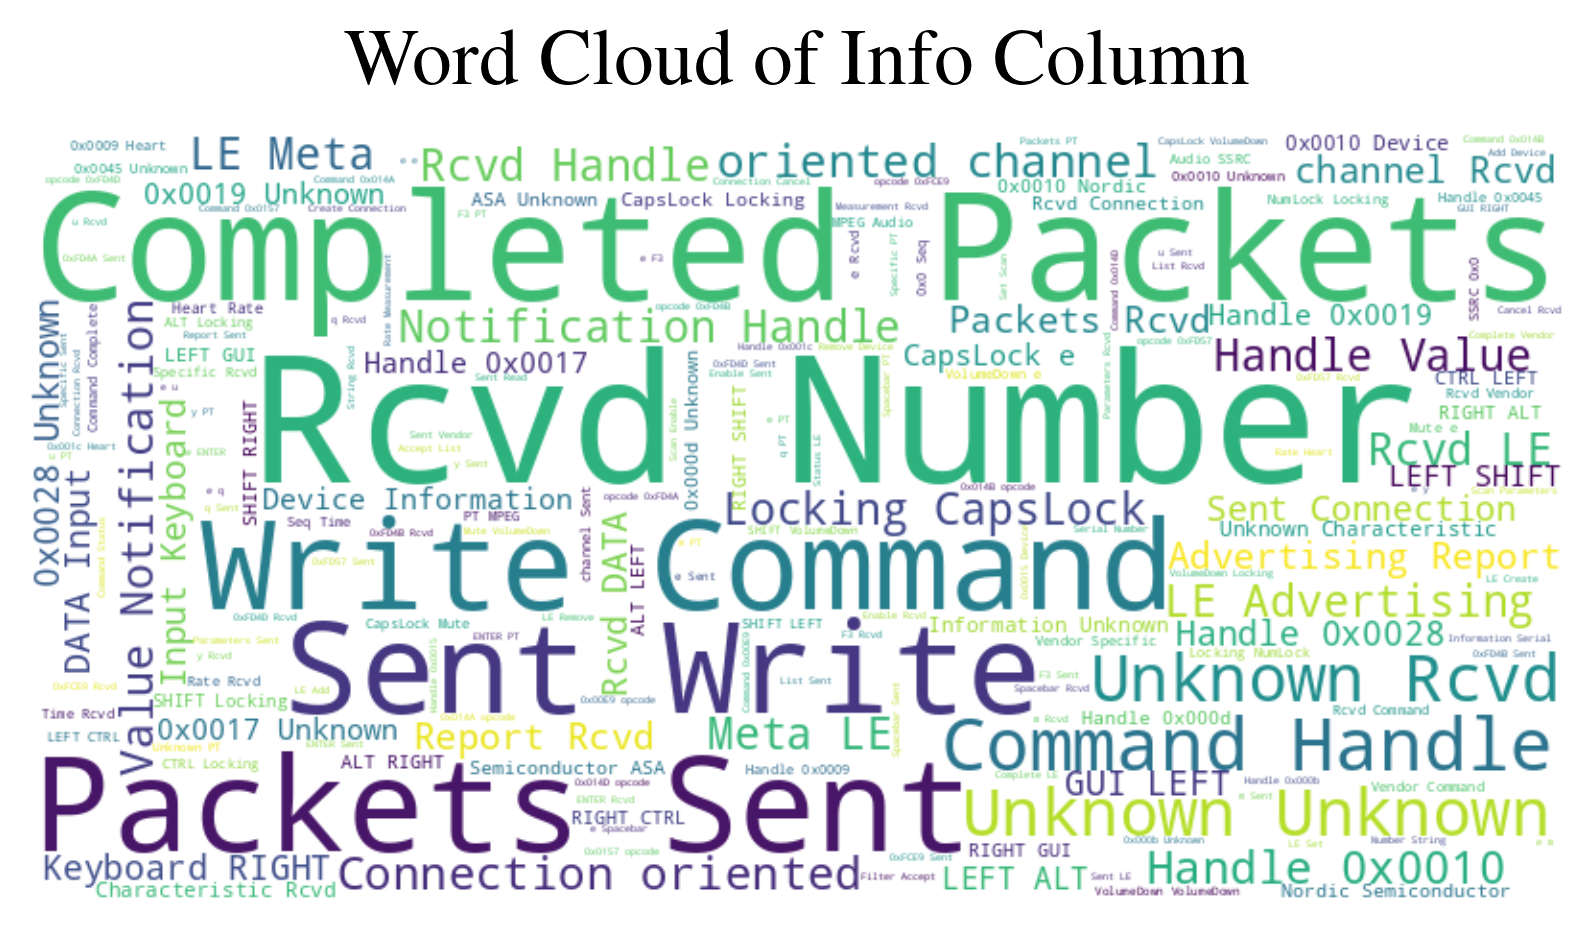

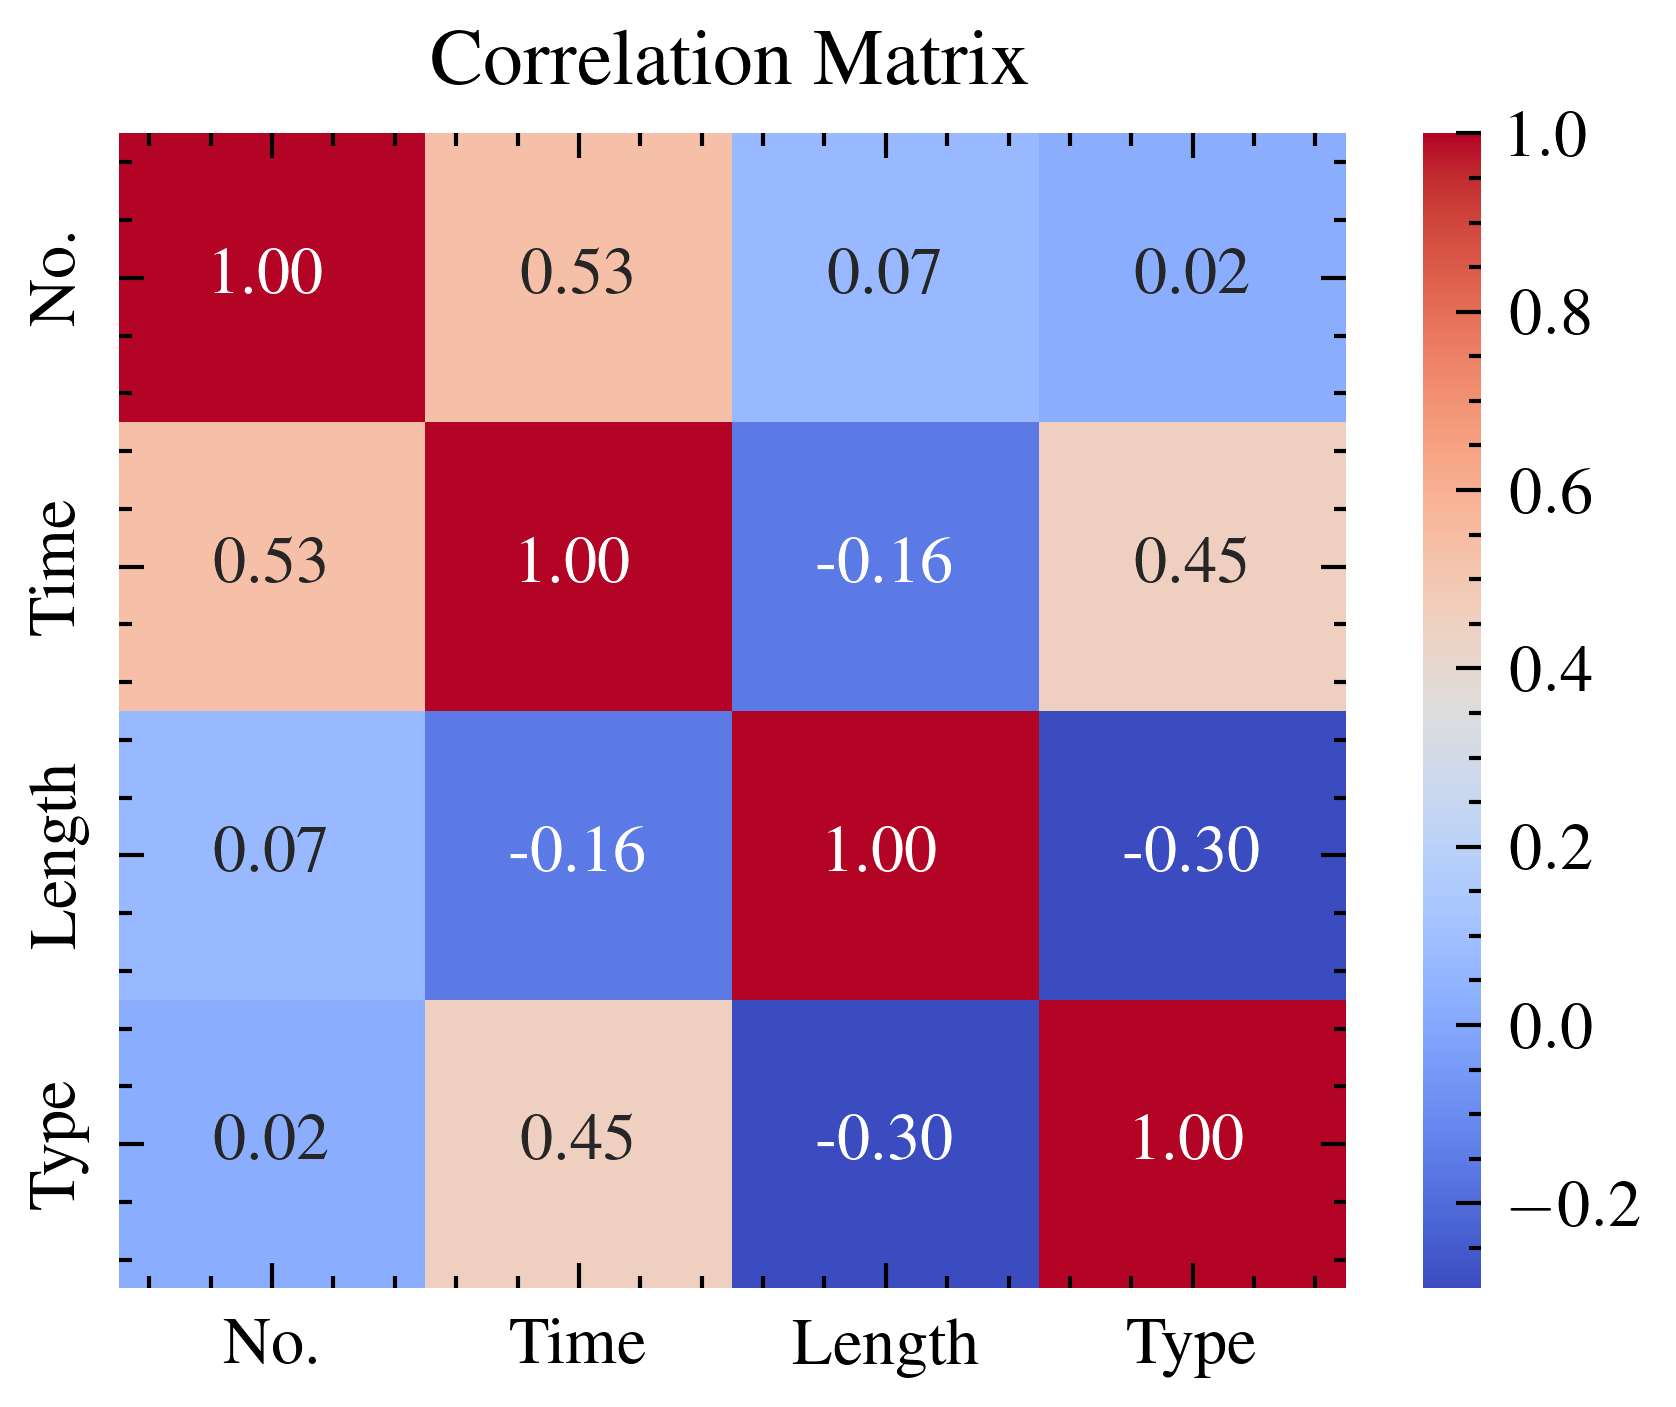

In [7]:
# training and testing with labels
plot_training = train_dataset.copy()
plot_training["Type"] = train_labels
plot_testing = test_dataset.copy()
plot_testing["Type"] = test_labels
dataset = pd.concat([plot_training, plot_testing], ignore_index=True)
# summary statistics
print(f"Training and Testing dataset statistics:\n{dataset.describe()}\n")

# remove length outliers
lower_bound, upper_bound = dataset["Length"].quantile([0.01, 0.85])
filtered_length = dataset["Length"][
    (dataset["Length"] > lower_bound) & (dataset["Length"] < upper_bound)
]
# histogram of length
plt.figure()
sns.histplot(
    x=filtered_length,
    hue=dataset["Type"],
    element="step",
    stat="density",
    common_norm=False,
)
plt.title("Distribution of Length by Type (Outliers Removed)")
plt.xlabel("Packet Length")
plt.ylabel("Density")
plt.legend(["Benign", "Attack"])
plt.show()

# bar chart for protocol usage
plt.figure()
sns.countplot(x="Protocol", hue="Type", data=dataset)
plt.title("Protocol Usage by Type")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "Attack"])
plt.show()

# bar chart for source usage
dataset["Source"] = dataset["Source"].apply(
    lambda x: x if len(x) <= 15 else x[:15] + "..."
)
plt.figure()
sns.countplot(
    x="Source",
    hue="Type",
    data=dataset,
    order=dataset["Source"].value_counts().index,
)
plt.title("Frequency of Packets by Source")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "Attack"])
plt.show()

# bar chart for destination usage
dataset["Destination"] = dataset["Destination"].apply(
    lambda x: x if len(x) <= 15 else x[:15] + "..."
)
plt.figure()
sns.countplot(
    x="Destination",
    hue="Type",
    data=dataset,
    order=dataset["Destination"].value_counts().index,
)
plt.title("Frequency of Packets by Destination")
plt.xlabel("Destination")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Benign", "Attack"])
plt.show()

# word cloud for info column
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(" ".join(dataset["Info"]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Info Column")
plt.show()

# correlation matrix
plt.figure()
sns.heatmap(
    dataset.select_dtypes(["number"]).corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
)
plt.title("Correlation Matrix")
plt.show()

## Feature Extraction

In [4]:
# load preprocessed datasets
train_dataset = pd.read_csv(PREPROCESSED_TRAIN)
test_dataset = pd.read_csv(PREPROCESSED_TEST)

In [5]:
# apply time delta encoding
train_time = train_dataset[["Time"]].diff().fillna(0)
train_time = csr_matrix(train_time)
test_time = test_dataset[["Time"]].diff().fillna(0)
test_time = csr_matrix(test_time)

# keep length as a feature
train_length = csr_matrix(train_dataset[["Length"]])
test_length = csr_matrix(test_dataset[["Length"]])

# combine features
train_features = hstack([train_time, train_length])
test_features = hstack([test_time, test_length])

In [6]:
# write features and models to files
save_npz(FEATURES_TRAIN, train_features)
save_npz(FEATURES_TEST, test_features)

Total number of features: 2


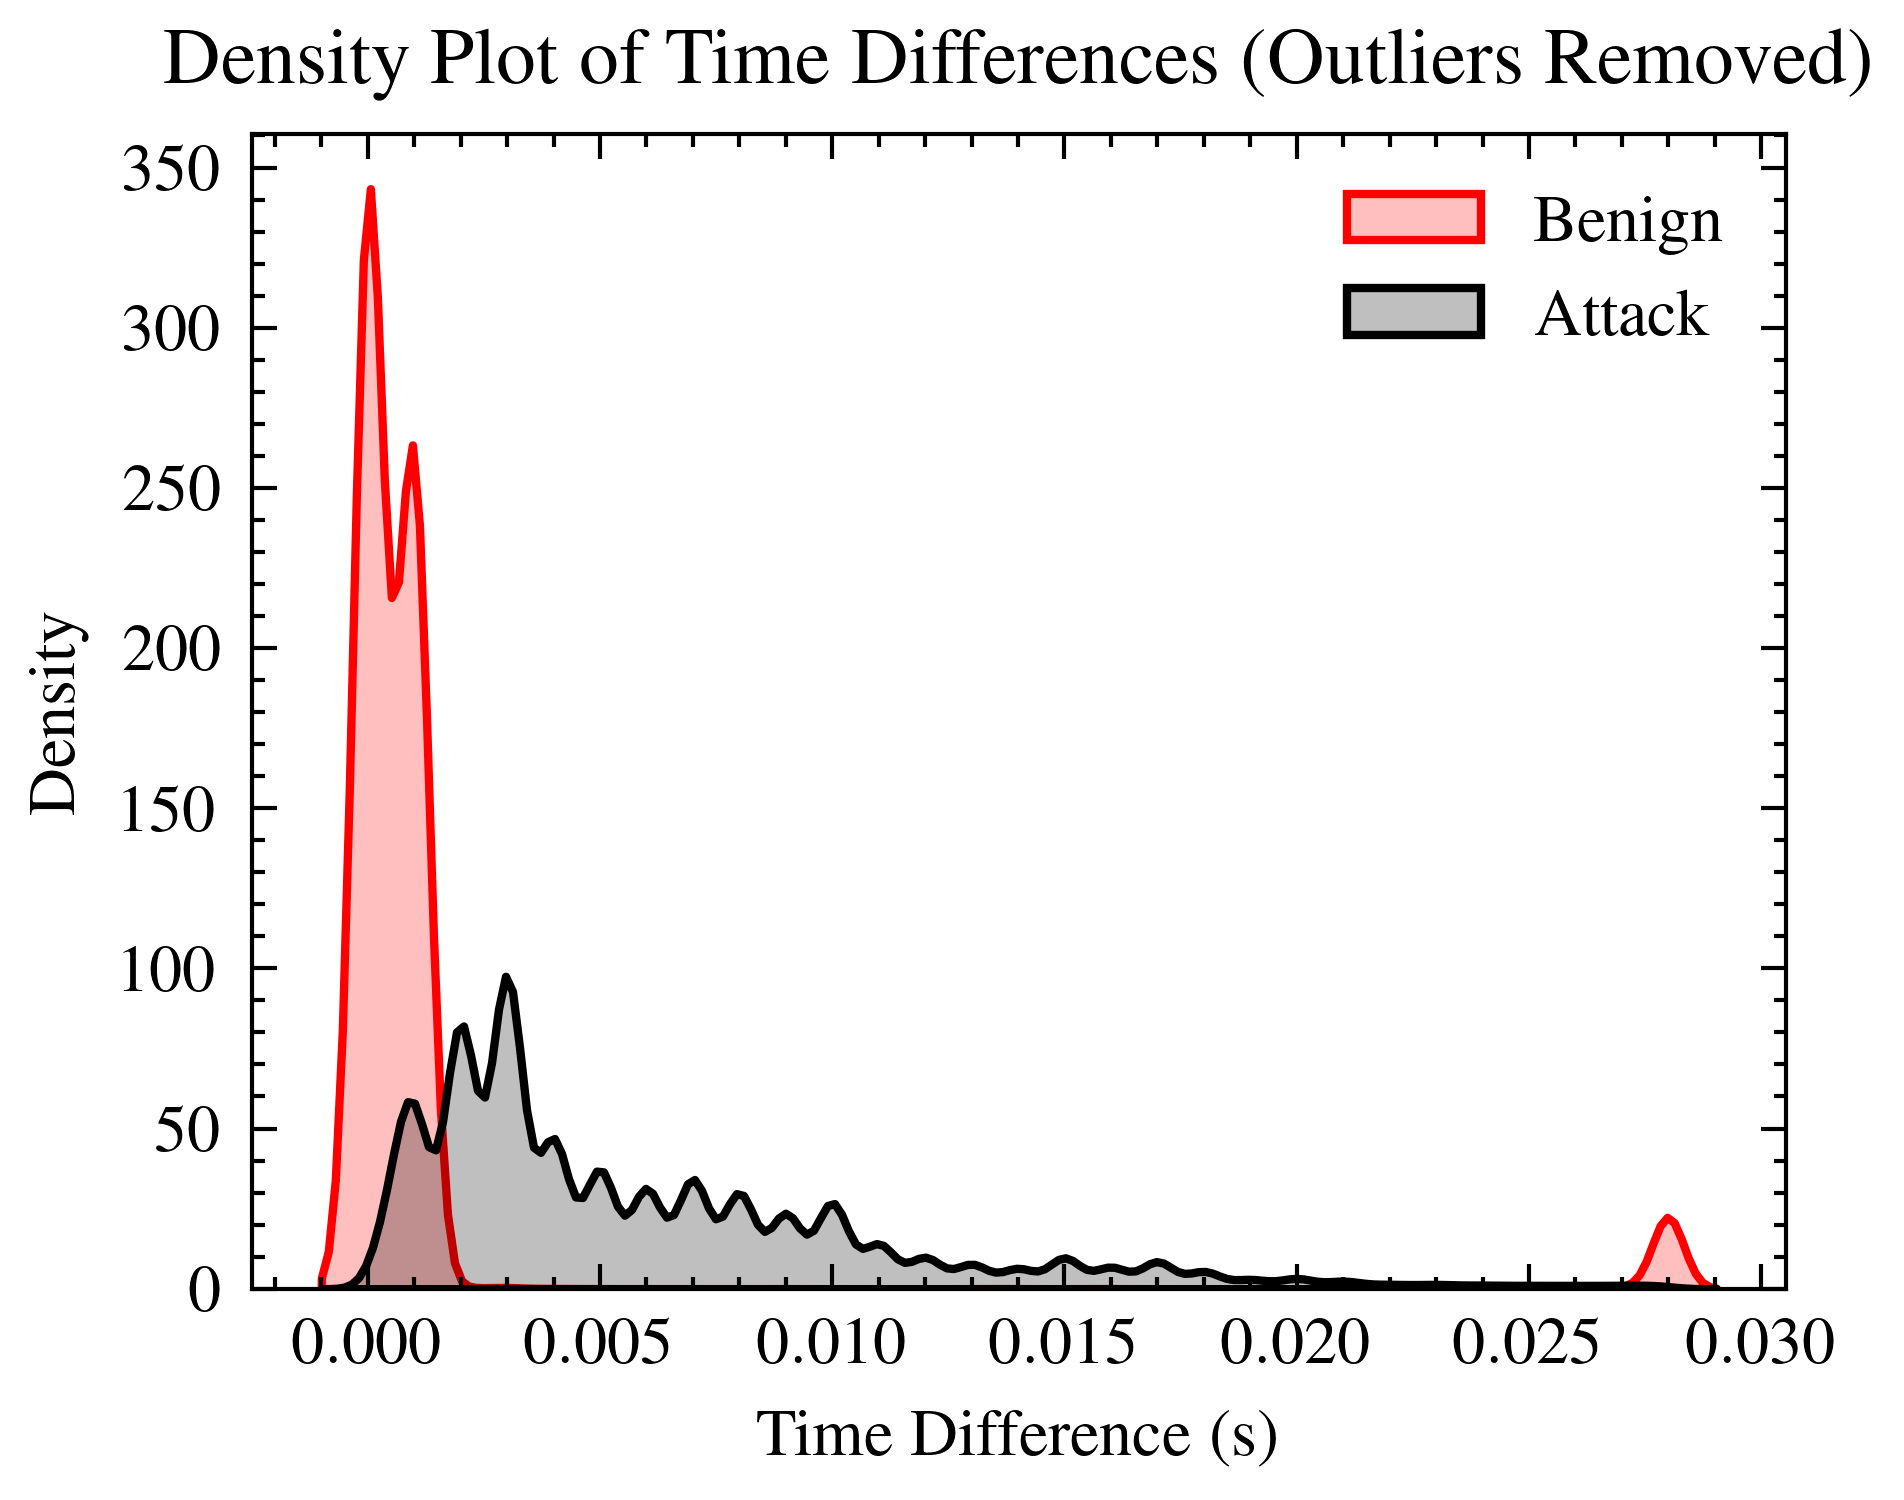

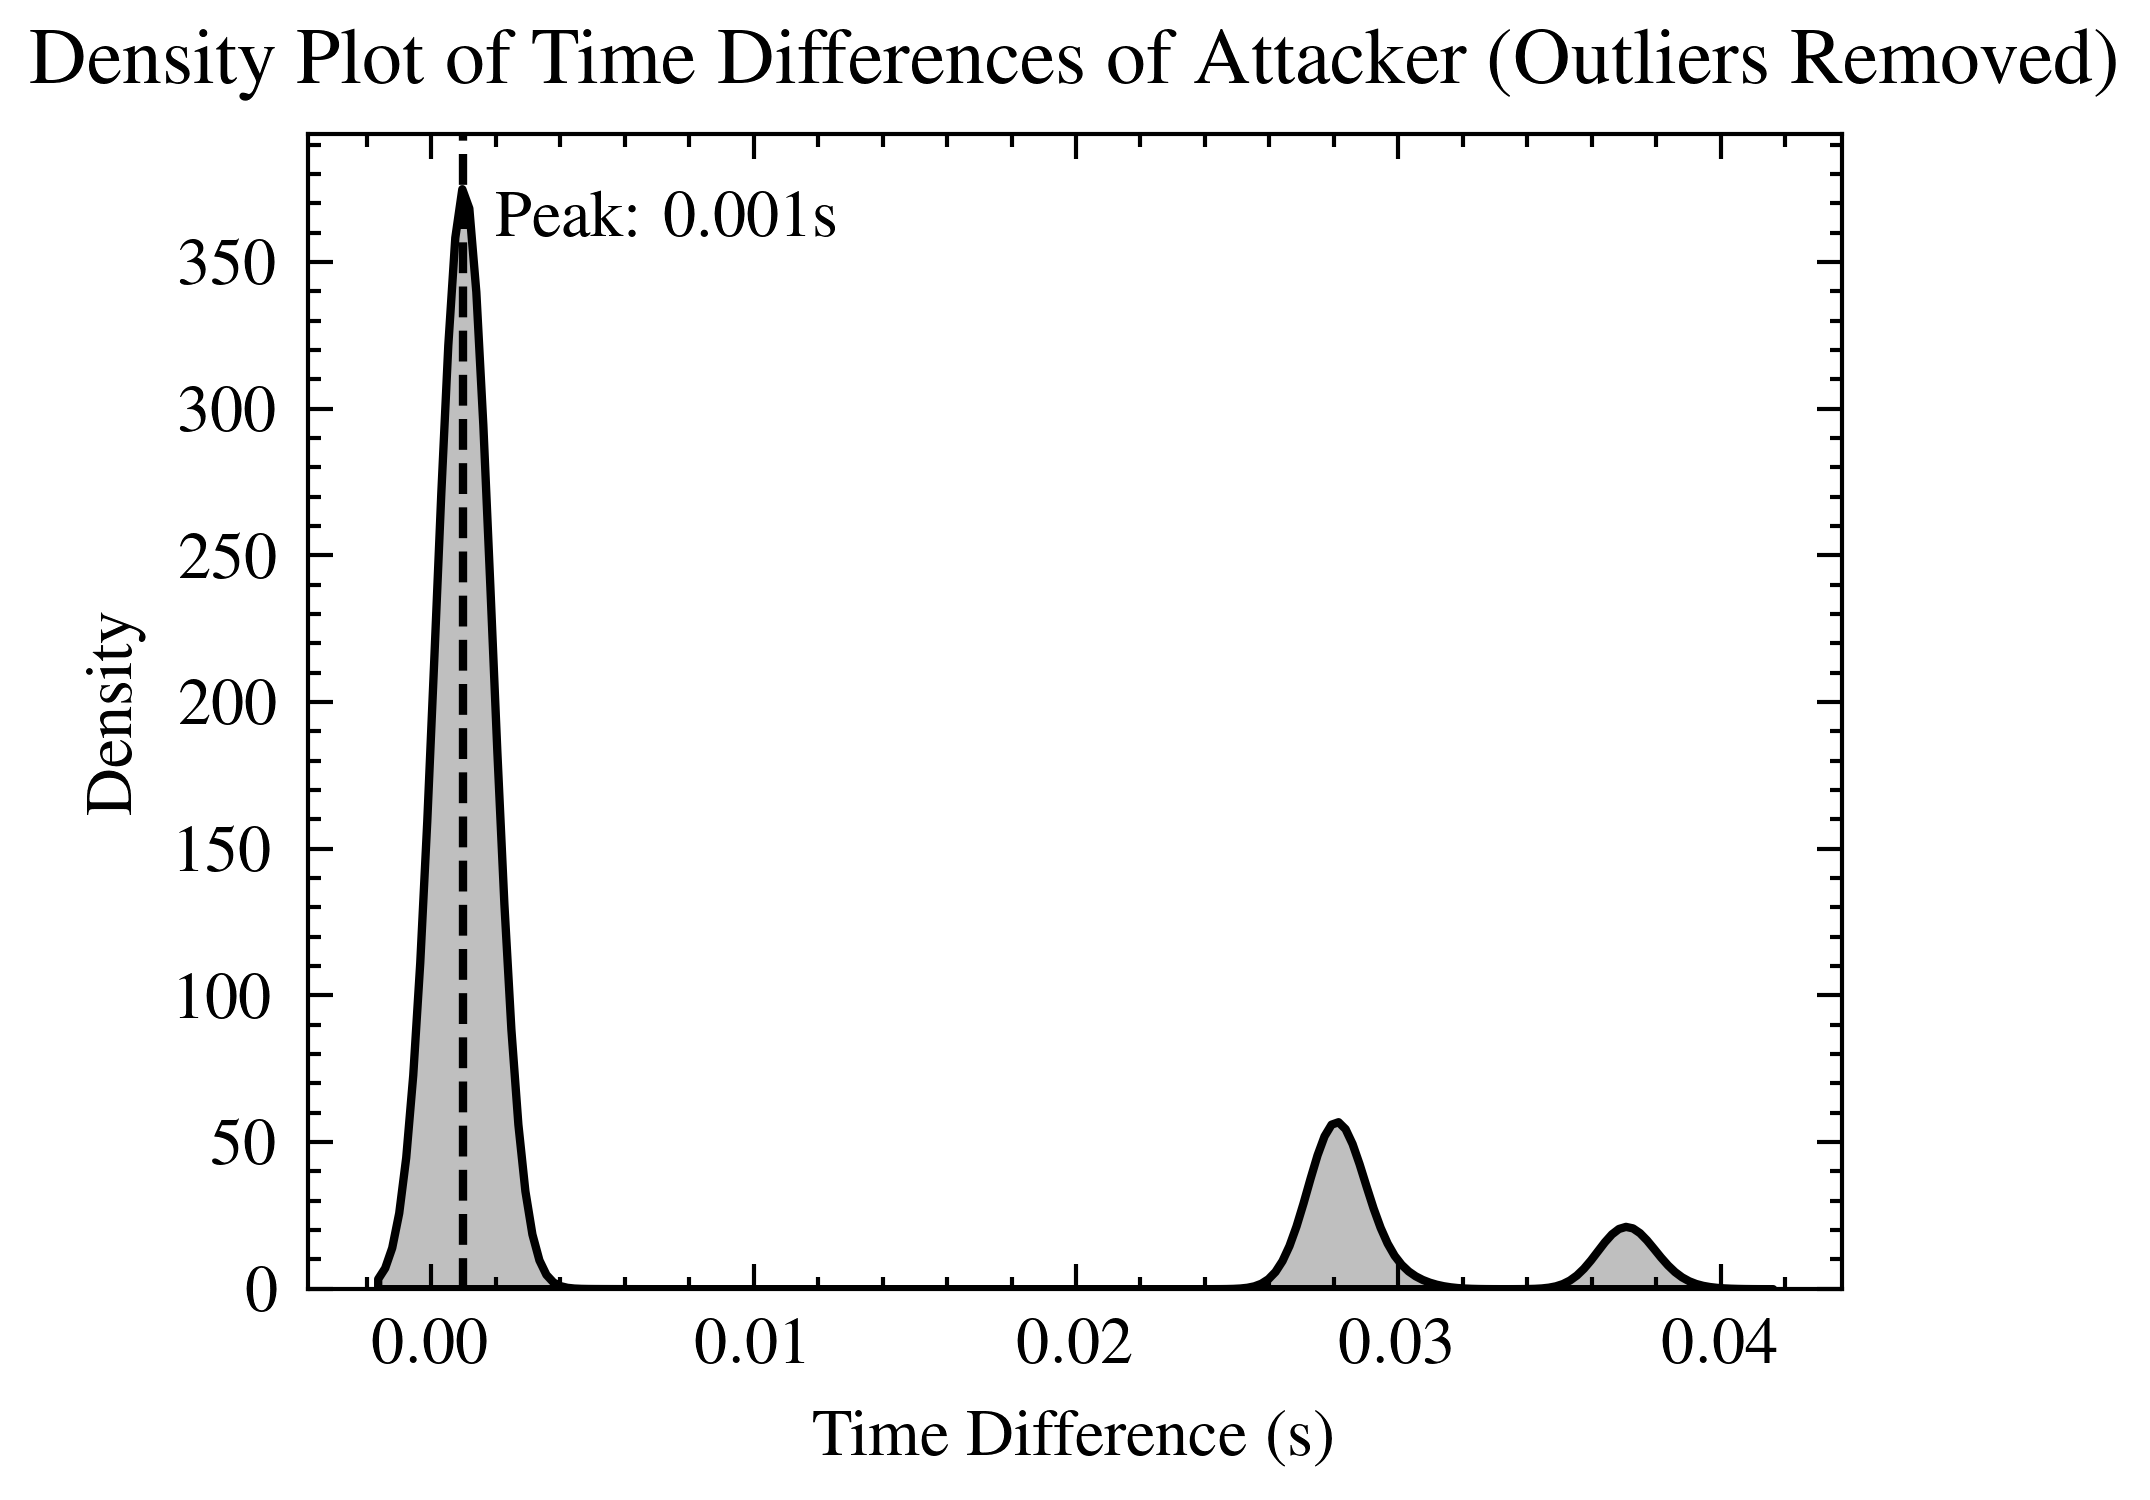

In [11]:
# report feature extraction results
print(f"Total number of features: {train_features.shape[1]}")

# filter out outliers from time differences
time_diffs = np.ravel(train_time.toarray())  # type: ignore
time_df = pd.DataFrame({"Time_Diffs": time_diffs, "Type": train_labels})
lower_bound, upper_bound = time_df["Time_Diffs"].quantile([0.05, 0.92])
filtered_time_df = time_df[
    (time_df["Time_Diffs"] > lower_bound)
    & (time_df["Time_Diffs"] < upper_bound)
]
# plot density of time differences
plt.figure()
sns.kdeplot(data=filtered_time_df, x="Time_Diffs", hue="Type", fill=True)
plt.title("Density Plot of Time Differences (Outliers Removed)")
plt.xlabel("Time Difference (s)")
plt.ylabel("Density")
plt.legend(["Benign", "Attack"])
plt.show()

# filter attack packets by second most common source
attack_source = dataset[dataset["Type"] == 1]["Source"].value_counts().index[1]
attack_source_ds = dataset[dataset["Source"] == attack_source]
# filter out outliers from time differences
attack_time = attack_source_ds[["Time"]].diff().fillna(0)
attack_time = csr_matrix(attack_time)
attack_time_diffs = np.ravel(attack_time.toarray())  # type: ignore
attack_time_df = pd.DataFrame(
    {"Time_Diffs": attack_time_diffs, "Type": attack_source_ds["Type"]}
)
lower_bound, upper_bound = attack_time_df["Time_Diffs"].quantile([0.05, 0.92])
filtered_attack_time_df = attack_time_df[
    (attack_time_df["Time_Diffs"] > lower_bound)
    & (attack_time_df["Time_Diffs"] < upper_bound)
]
# plot density of time differences (add dashed vertical line at peak)
plt.figure()
sns.kdeplot(
    data=filtered_attack_time_df,
    x="Time_Diffs",
    fill=True,
)
mode_time_diffs = filtered_attack_time_df["Time_Diffs"].mode()[0]
plt.axvline(x=mode_time_diffs, color="black", linestyle="--", label="Peak")
plt.text(
    x=mode_time_diffs + 0.001,
    y=plt.ylim()[1] * 0.95,
    s=f"Peak: {mode_time_diffs:.3f}s",
    verticalalignment="top",
)
plt.title(f"Density Plot of Time Differences of Attacker (Outliers Removed)")
plt.xlabel("Time Difference (s)")
plt.ylabel("Density")
plt.show()

## Model Training

In [7]:
# load features and labels
train_features = load_npz(FEATURES_TRAIN)
train_labels = np.load(LABELS_TRAIN)

In [8]:
# report hardware information
print("Hardware information:")
print(f"\tPlatform: {os.uname().sysname}")
print(f"\tProcessor: {os.uname().machine}")
print(f"\tNumber of CPU cores: {os.cpu_count()}")
mem = os.sysconf("SC_PAGE_SIZE") * os.sysconf("SC_PHYS_PAGES") / 1024**3
print(f"\tMemory available: {mem:.2f} GB\n")

# train model
model = RandomForestClassifier(n_jobs=-1, verbose=1)
_ = model.fit(train_features, train_labels)
model.verbose = 0  # type: ignore

Hardware information:
	Platform: Darwin
	Processor: arm64
	Number of CPU cores: 8
	Memory available: 8.00 GB



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


In [9]:
# write model to file
_ = dump(model, MODEL)

## Evaluation

In [10]:
# load model and features
model = load(MODEL)
test_features = load_npz(FEATURES_TEST)
test_labels = np.load(LABELS_TEST)

Train accuracy: 0.9971287425439148

Confusion matrix:
[[264648    839]
 [   646 251062]]

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    265487
           1       1.00      1.00      1.00    251708

    accuracy                           1.00    517195
   macro avg       1.00      1.00      1.00    517195
weighted avg       1.00      1.00      1.00    517195



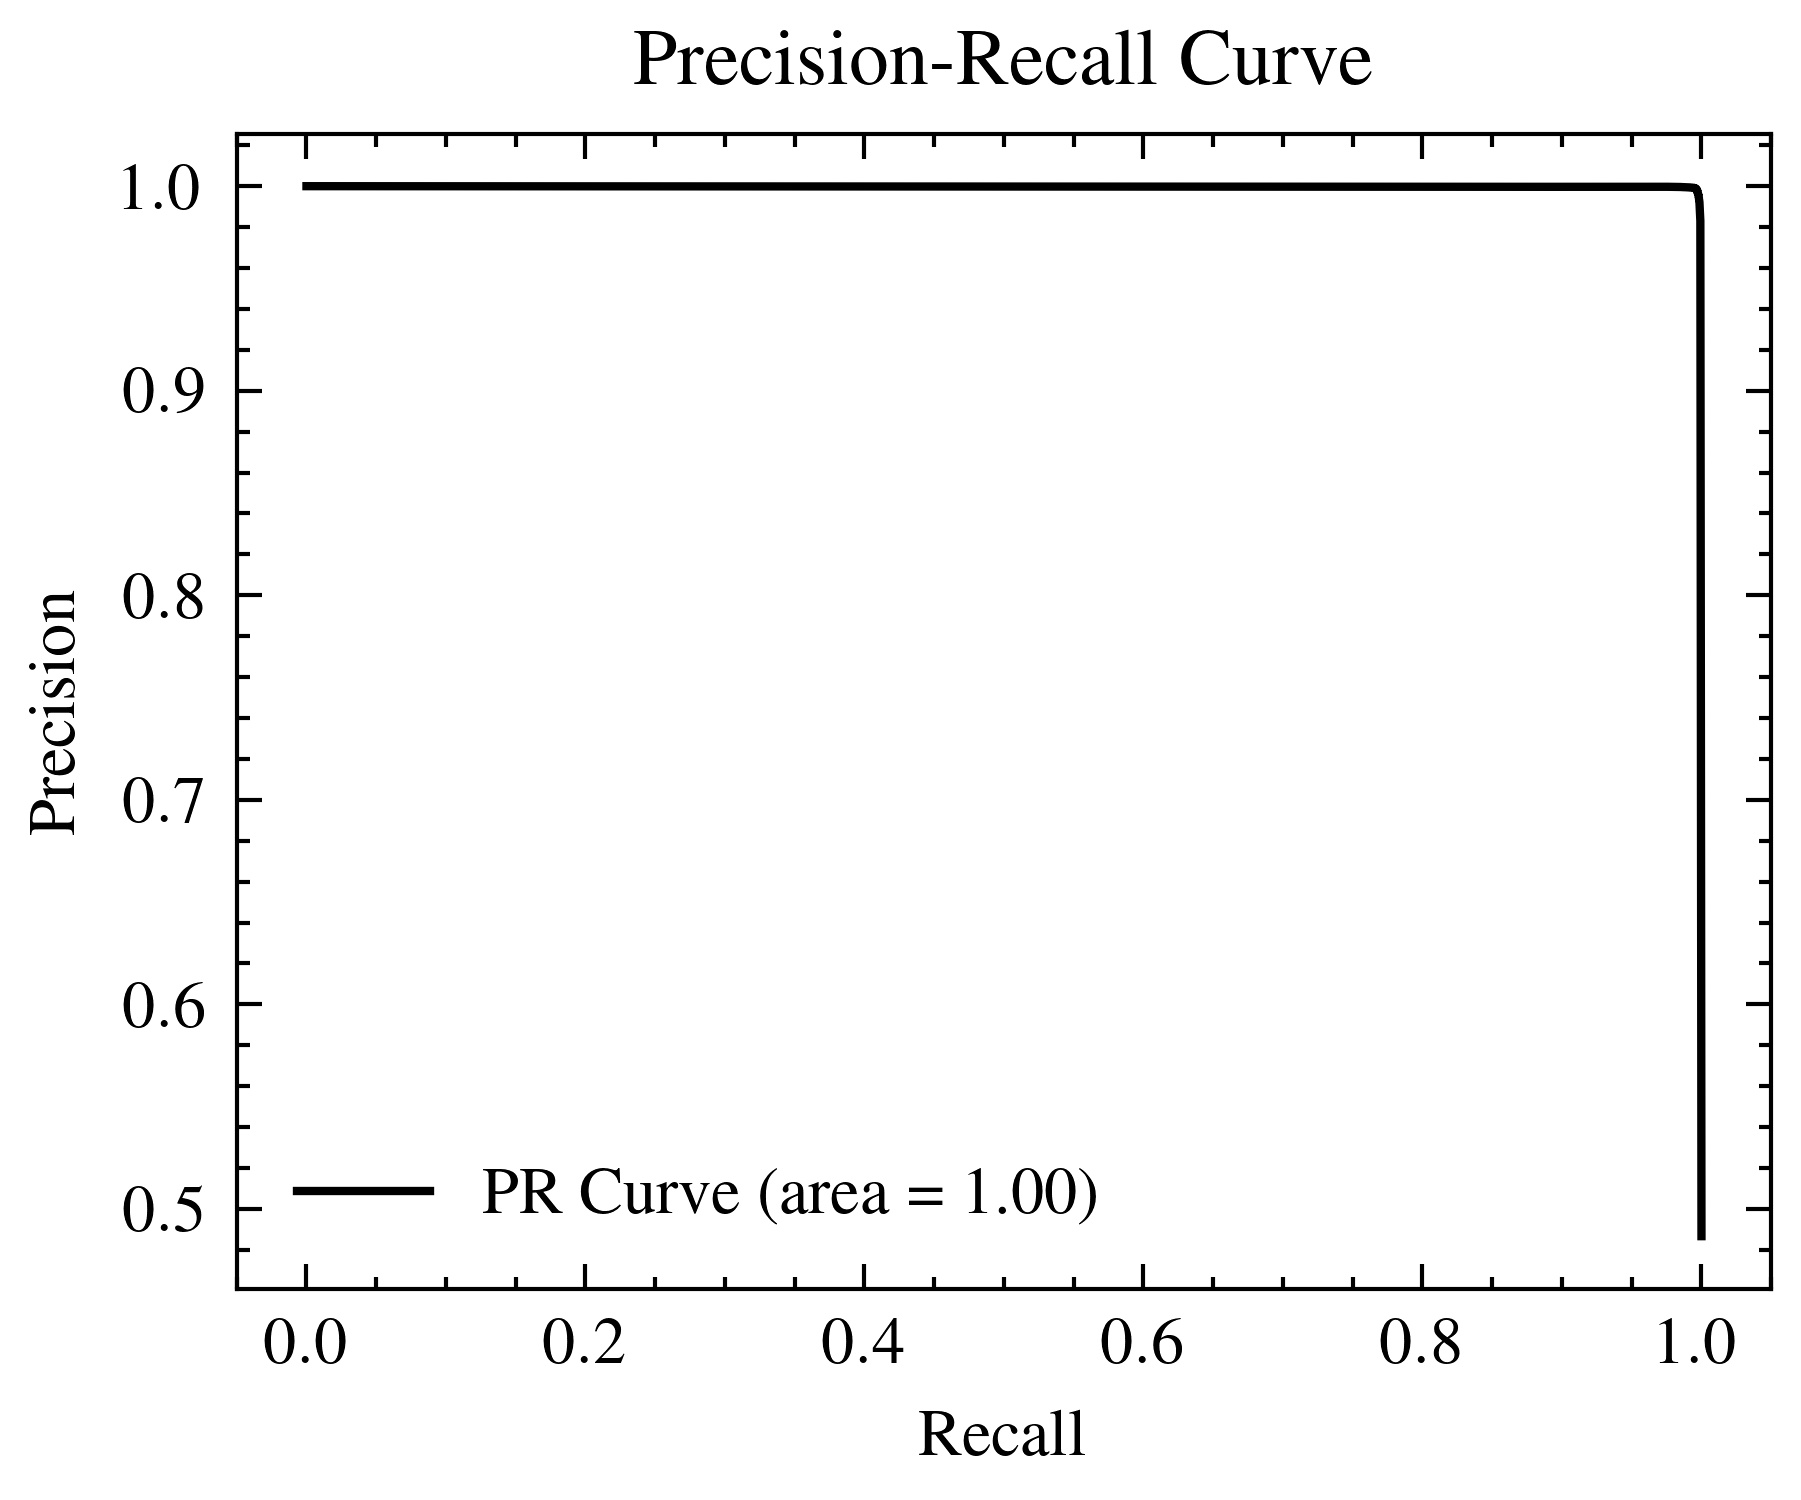

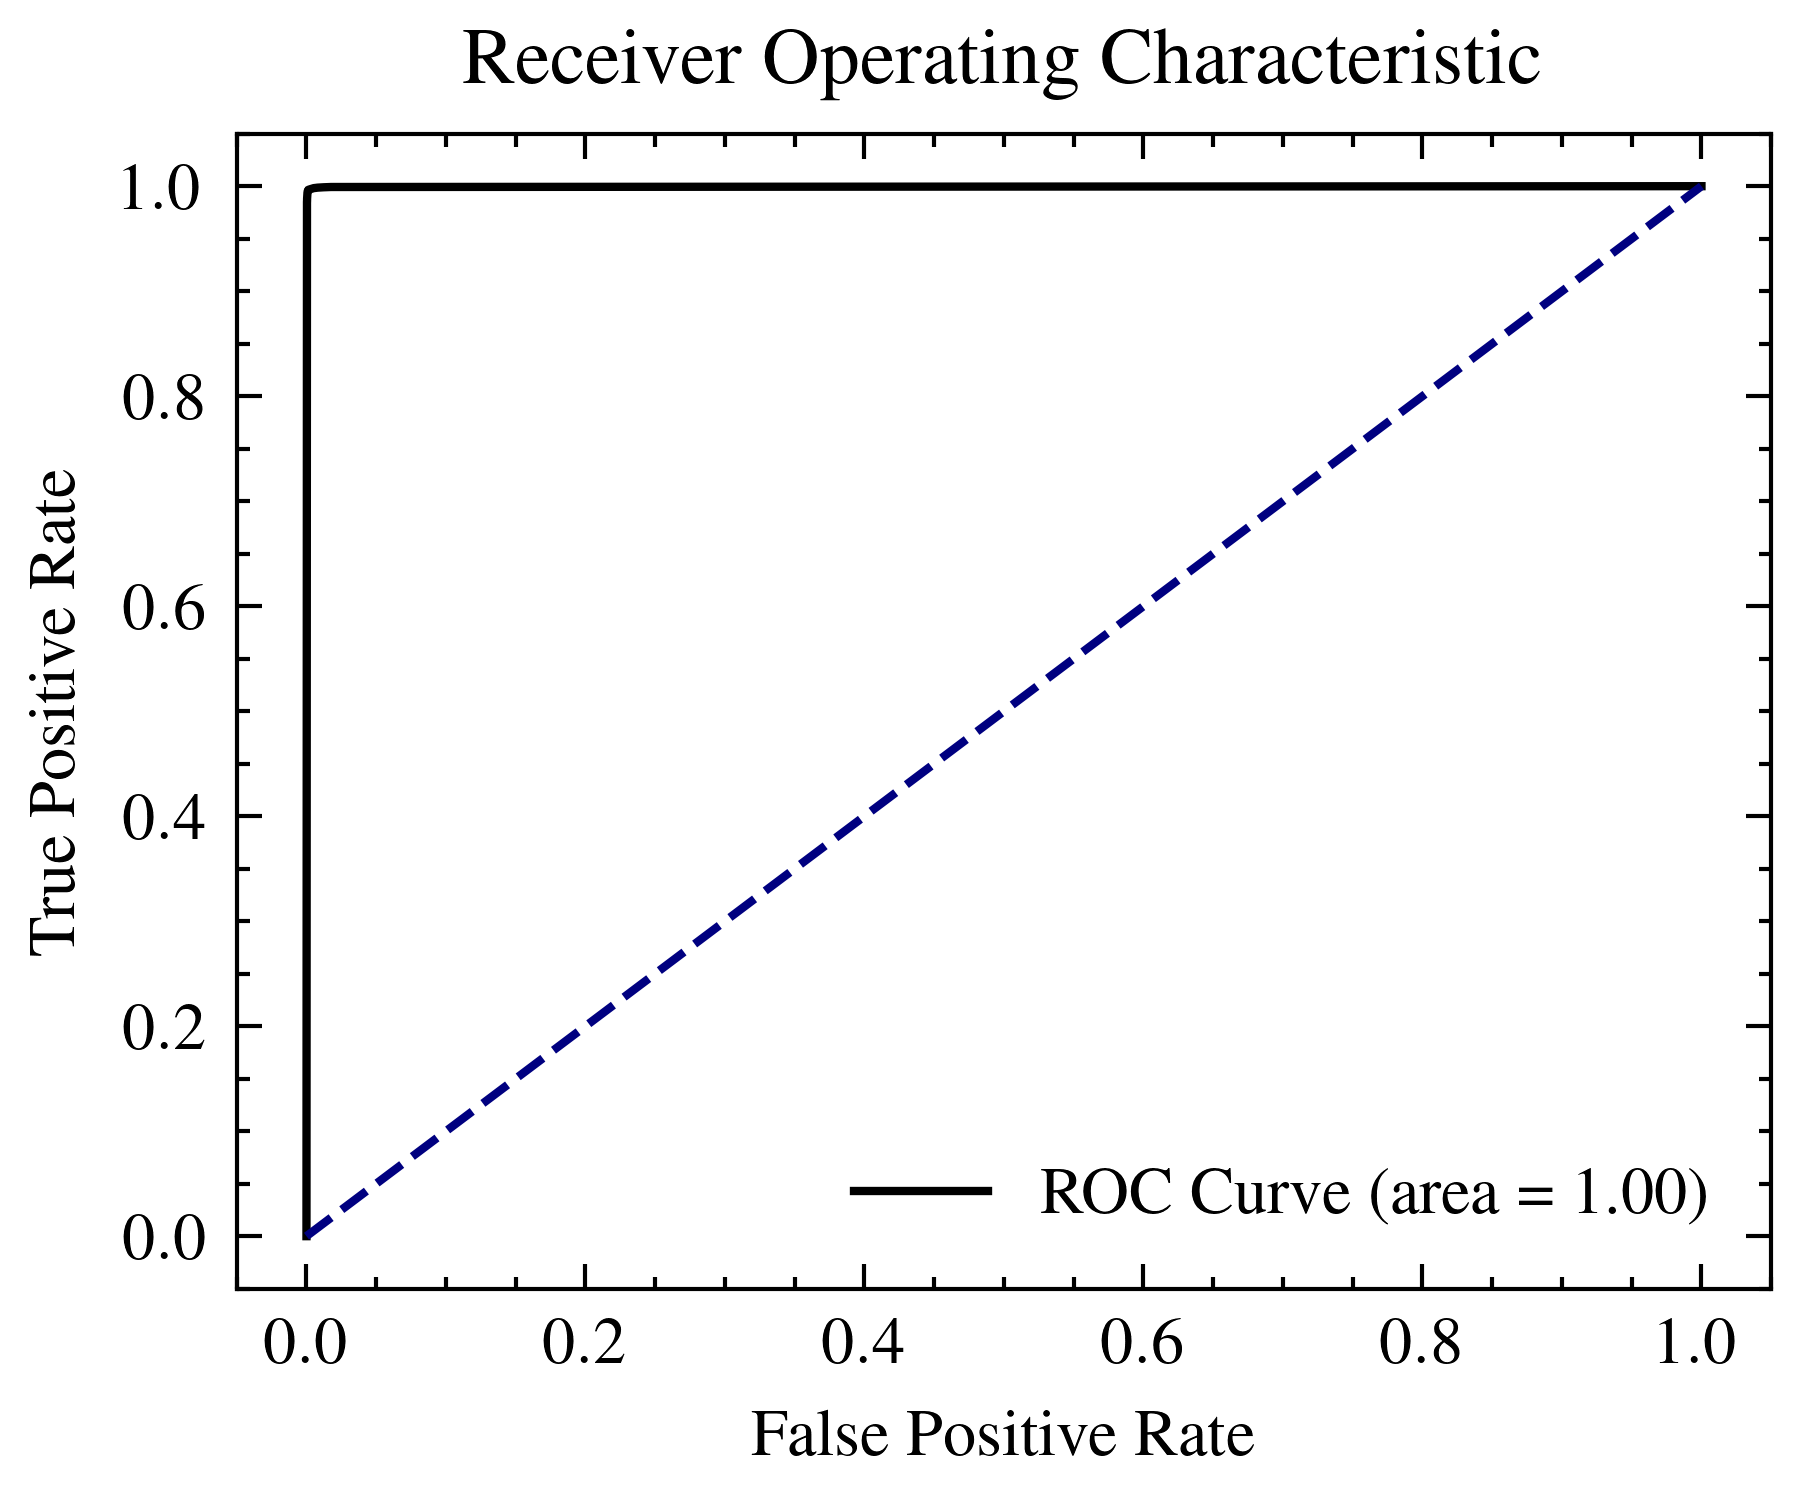

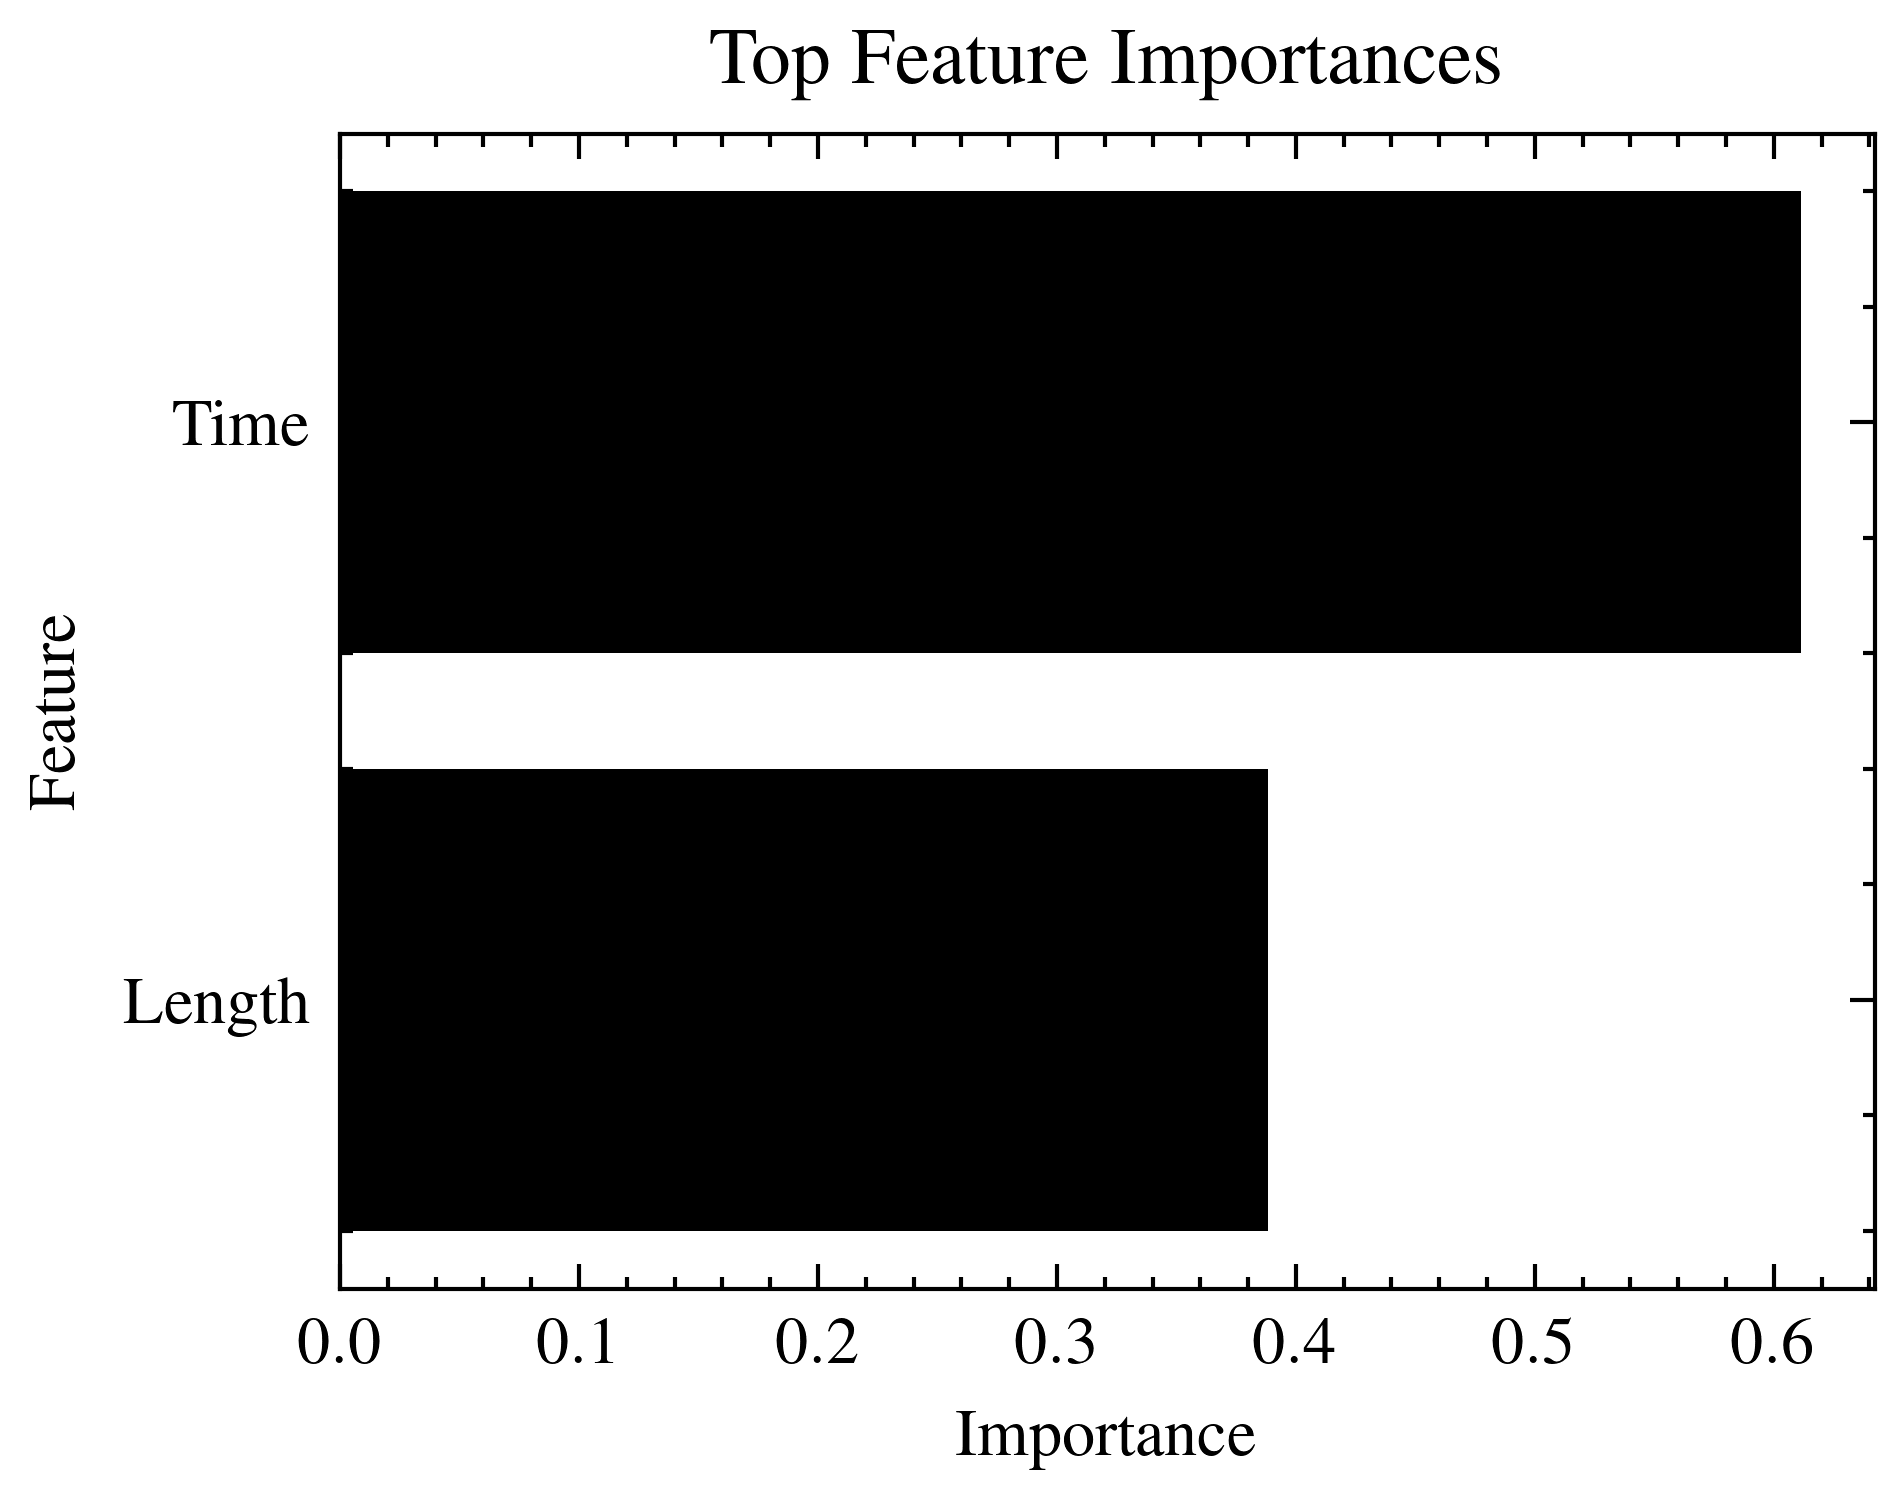

In [13]:
# predictions
predictions = model.predict(test_features)
predictions_prob = model.predict_proba(test_features)[:, 1]

# evaluate model
accuracy = metrics.accuracy_score(test_labels, predictions)
print(f"Train accuracy: {accuracy}\n")
conf_matrix = metrics.confusion_matrix(test_labels, predictions)
print(f"Confusion matrix:\n{conf_matrix}\n")
report = metrics.classification_report(test_labels, predictions)
print(f"Classification report:\n{report}")

# compute precision-recall curve and area
precision, recall, _ = metrics.precision_recall_curve(
    test_labels, predictions_prob
)
pr_auc = metrics.auc(recall, precision)
# plot precision-recall curve
plt.figure()
plt.plot(recall, precision, label=f"PR Curve (area = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

# compute roc curve and area
fpr, tpr, _ = metrics.roc_curve(test_labels, predictions_prob)
roc_auc = metrics.auc(fpr, tpr)
# plot roc curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

# combine all feature names
all_feature_names = list(["Time", "Length"])
# ensure the number of names matches the number of features
assert len(all_feature_names) == train_features.shape[1]
# prepare feature importances
importances = model.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": all_feature_names, "Importance": importances}
)
sorted_feature_importance = feature_importance_df.sort_values(
    by="Importance", ascending=False
)

# plot feature importance
top_features = sorted_feature_importance.head(15)  # top n features
plt.figure()
sns.barplot(x="Importance", y="Feature", data=top_features)
plt.title("Top Feature Importances")
plt.show()